<a href="https://colab.research.google.com/github/carzyjoey/IFR_PCL_omicron_test_kits/blob/main/jupyter%2Bchart22_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 第11章 关联规则与文本挖掘

In [1]:
## 输出高清图像
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
## 图像显示中文的问题
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False

import seaborn as sns 
sns.set(font= "Kaiti",style="ticks",font_scale=1.4)

In [2]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 15.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=f5cc4281ecbdc0a0b9e09b600e49bf560e9144d35c0ecf15ea16623c2f970ca7
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=14e7f47baa13945d197584df1ff7f561f297f3debe7241bfb463df7dadfdfd9a
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 挖掘频繁项集和关联规则
from mlxtend.frequent_patterns import *
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.plotting import *

import networkx as nx
import glob
import re
import string
from wordcloud import WordCloud
import jieba
import csv


from sklearn.feature_extraction.text import *
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram,linkage,fcluster
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score


from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models

import altair as alt

## 忽略提醒
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [4]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# copy Gdrive module 到 colab root(content)

# !cp /content/drive/MyDrive/Colab/price2884.csv /content

!cp /content/drive/MyDrive/Colab/data/mushroom.dat /content

In [6]:
##  读取数据,根据文本文件进行数据读取
ARdf = pd.read_table("mushroom.dat",header=None)
print(ARdf.head())

## 读取的数据中每行只有一个样本，每个样本中包含着不同的特性

                                                   0
0  1 3 9 13 23 25 34 36 38 40 52 54 59 63 67 76 8...
1  2 3 9 14 23 26 34 36 39 40 52 55 59 63 67 76 8...
2  2 4 9 15 23 27 34 36 39 41 52 55 59 63 67 76 8...
3  1 3 10 15 23 25 34 36 38 41 52 54 59 63 67 76 ...
4  2 3 9 16 24 28 34 37 39 40 53 54 59 63 67 76 8...


In [7]:
## 针对上面的数据在进行关联规则之前，需要将其处理为列表
ARlist = ARdf.iloc[:,0].str.split(pat = " ")  #使用空格将特征之间进行切分
ARlist = ARlist.str[:-1]    ## 剔除最后一个空格
ARlist = ARlist.tolist()    #数据转化为列表
print("序列的数量:",len(ARlist))
print("包含的特征内容:\n",np.unique(sum(ARlist, [])))
print("类目的数量:",len(np.unique(sum(ARlist, []))))

## 可以发现在二维的数据列表中，每个子列表中包含不同的特性，一共有119个特性

序列的数量: 8124
包含的特征内容:
 ['1' '10' '100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '11'
 '110' '111' '112' '113' '114' '115' '116' '117' '118' '119' '12' '13'
 '14' '15' '16' '17' '18' '19' '2' '20' '21' '22' '23' '24' '25' '26' '27'
 '28' '29' '3' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '4' '40'
 '41' '42' '43' '44' '45' '46' '47' '48' '49' '5' '50' '51' '52' '53' '54'
 '55' '56' '57' '58' '59' '6' '60' '61' '62' '63' '64' '65' '66' '67' '68'
 '69' '7' '70' '71' '72' '73' '74' '75' '76' '77' '78' '79' '8' '80' '81'
 '82' '83' '84' '85' '86' '87' '88' '89' '9' '90' '91' '92' '93' '94' '95'
 '96' '97' '98' '99']
类目的数量: 119


In [8]:
## 为了使用mlxtend库进行关联规则的相关分析，对列表数据进行处理
te = TransactionEncoder()
AR_array = te.fit(ARlist).transform(ARlist)
df = pd.DataFrame(AR_array, columns=te.columns_)
df

## 可以发现在数据表中，每个特性作为列名，每个样本对应着行，如果样本中有某种特性，则对应的取值True,否则为False

1     10    100    101    102    103    104    105    106    107  \
0      True  False  False  False  False  False  False  False  False   True   
1     False  False  False  False  False  False  False  False  False  False   
2     False  False  False  False  False  False  False  False  False  False   
3      True   True  False  False  False  False  False  False  False   True   
4     False  False  False  False  False  False  False  False  False  False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
8119  False  False  False  False  False  False  False  False   True  False   
8120  False  False  False  False  False  False  False  False   True  False   
8121  False  False  False  False  False  False  False  False   True  False   
8122   True   True  False  False   True  False  False  False  False  False   
8123  False  False  False  False  False  False   True  False  False  False   

      ...    90     91     92     93     94     95     96     97     98     99  
0     ...  True  False  False   True  False  False  False  False   True  False  
1     ...  True  False  False   True  False  False  False  False  False   True  
2     ...  True  False  False   True  False  False  False  False  False   True  
3     ...  True  False  False   True  False  False  False  False   True  False  
4     ...  True  False  False  False   True  False  False  False  False   True  
...   ...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
8119  ...  True  False  False   True  False  False  False  False  False  False  
8120  ...  True  False  False   True  False  False  False  False  False  False  
8121  ...  True  False  False   True  False  False  False  False  False  False  
8122  ...  True  False  False  False   True  False  False  False  False  False  
8123  ...  True  False  False   True  False  False  False  False  False  False  

[8124 rows x 119 columns]

#### 12.2.1 FPGrowth关联规则挖掘

In [9]:
## 使用FPGrowth算法获取数据中的频繁项集
iterm_fre = fpgrowth(df, min_support=0.5,  ## 支持度阈值
                     max_len = 4,          ## 项集中的最大元素数量
                     use_colnames=True)    ## 输出中使用列名
## 计算每个itemsets的元素数量
iterm_fre["length"] = iterm_fre["itemsets"].apply(lambda x: len(x))
print(iterm_fre.head())
iterm_fre 

NameError: ignored

In [10]:
## 可视化出1个元素和2个元素的频繁项集的支持度大小

## 可视化出1个元素的频繁项集的支持度大小
plotdata = iterm_fre[iterm_fre.length == 1].sort_values("support")
plotdata.plot(kind = "bar",x = "itemsets",y= "support",
              figsize = (10,6),legend=None,width = 0.8)
plt.title("频繁项集的支持度")
plt.ylabel("频率")
plt.xlabel("")
plt.show()

## 可视化出2个元素的频繁项集的支持度大小
plotdata = iterm_fre[iterm_fre.length == 2].sort_values("support")
plotdata.plot(kind = "bar",x = "itemsets",y= "support",
              figsize = (10,6),legend=None,width = 0.8)
plt.title("频繁项集的支持度")
plt.ylabel("频率")
plt.xlabel("")
plt.show()

## 可视化出3个元素的频繁项集的支持度大小
plotdata = iterm_fre[iterm_fre.length == 3].sort_values("support")
plotdata.plot(kind = "bar",x = "itemsets",y= "support",
              figsize = (10,6),legend=None,width = 0.8)
plt.title("频繁项集的支持度")
plt.ylabel("频率")
plt.xlabel("")
plt.xticks(size = 14)
plt.show()

## 可视化出4个元素的频繁项集的支持度大小
plotdata = iterm_fre[iterm_fre.length == 4].sort_values("support")
plotdata.plot(kind = "bar",x = "itemsets",y= "support",
              figsize = (10,6),legend=None,width = 0.8)
plt.title("频繁项集的支持度")
plt.ylabel("频率")
plt.xlabel("")
plt.show()

NameError: ignored

#### 11.3.2 《三国演义》文本预处理


In [12]:
# copy Gdrive module 到 colab root(content)

# !cp /content/drive/MyDrive/Colab/price2884.csv /content

!cp /content/drive/MyDrive/Colab/data/综合停用词表1.txt /content

In [14]:
!cp /content/drive/MyDrive/Colab/data/三国演义.txt /content

In [16]:
## 读取停用词数据
stopword = pd.read_csv("综合停用词表1.txt",header=None,
                       names = ["Stopwords"],quoting=csv.QUOTE_NONE)
## 读取三国演义数据
TK_df = pd.read_csv("三国演义.txt",sep="\t")
TK_df.head(5)

Name                                            content
0  宴桃园豪杰三结义,斩黄巾英雄首立功  滚滚长江东逝水，浪花淘尽英雄。是非成败转头空。青山依旧在，几度夕阳红。白发渔樵江渚上，惯看秋...
1    张翼德怒鞭督邮,何国舅谋诛宦竖  且说董卓字仲颖，陇西临洮人也，官拜河东太守，自来骄傲。当日怠慢了玄德，张飞性发，便欲杀之。玄...
2  议温明董卓叱丁原,馈金珠李肃说吕布  且说曹操当日对何进曰：“宦官之祸，古今皆有；但世主不当假之权宠，使至于此。若欲治罪，当除元恶...
3    废汉帝陈留践位,谋董贼孟德献刀  且说董卓欲杀袁绍，李儒止之曰：“事未可定，不可妄杀。”袁绍手提宝剑，辞别百官而出，悬节东门，...
4  发矫诏诸镇应曹公,破关兵三英战吕布  却说陈宫临欲下手杀曹操，忽转念曰：“我为国家跟他到此，杀之不义。不若弃而他往。”插剑上马，不...

#### 分词

In [17]:
## 不使用词典分词
print(list(jieba.cut(TK_df.Name[2], cut_all=True)))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.799 seconds.
DEBUG:jieba:Loading model cost 1.799 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


['议', '温', '明', '董卓', '叱', '丁', '原', ',', '馈', '金', '珠', '李', '肃', '说', '吕布']


In [18]:
print(list(jieba.cut(TK_df.Name[2])))

['议温明', '董卓', '叱丁原', ',', '馈金珠', '李肃', '说', '吕布']


In [19]:
!cp /content/drive/MyDrive/Colab/data/三国演义词典.txt /content

In [20]:
## 添加自定义词典
jieba.load_userdict("三国演义词典.txt")

In [21]:
## 使用词典分词
print(list(jieba.cut(TK_df.Name[2], cut_all=True)))

['议温明董卓叱丁原', '董卓', '叱', '丁原', ',', '馈金珠李肃说吕布', '李肃', '说', '吕布']


In [22]:
## 使用词典分词
print(list(jieba.cut(TK_df.Name[2])))

['议温明董卓叱丁原', ',', '馈金珠李肃说吕布']


In [23]:
## 数据表的行数
row,col = TK_df.shape
## 预定义列表
TK_df["cutword"] = "cutword"
for ii in np.arange(row):
    ## 分词
    cutwords = list(jieba.cut(TK_df.content[ii], cut_all=True))
    ## 去除长度为1的词
    cutwords = pd.Series(cutwords)
    cutwords = cutwords[cutwords.apply(len)>1]
    ## 去停用词
    cutwords = cutwords[~cutwords.isin(stopword.Stopwords)]
    TK_df.cutword[ii] = cutwords.values

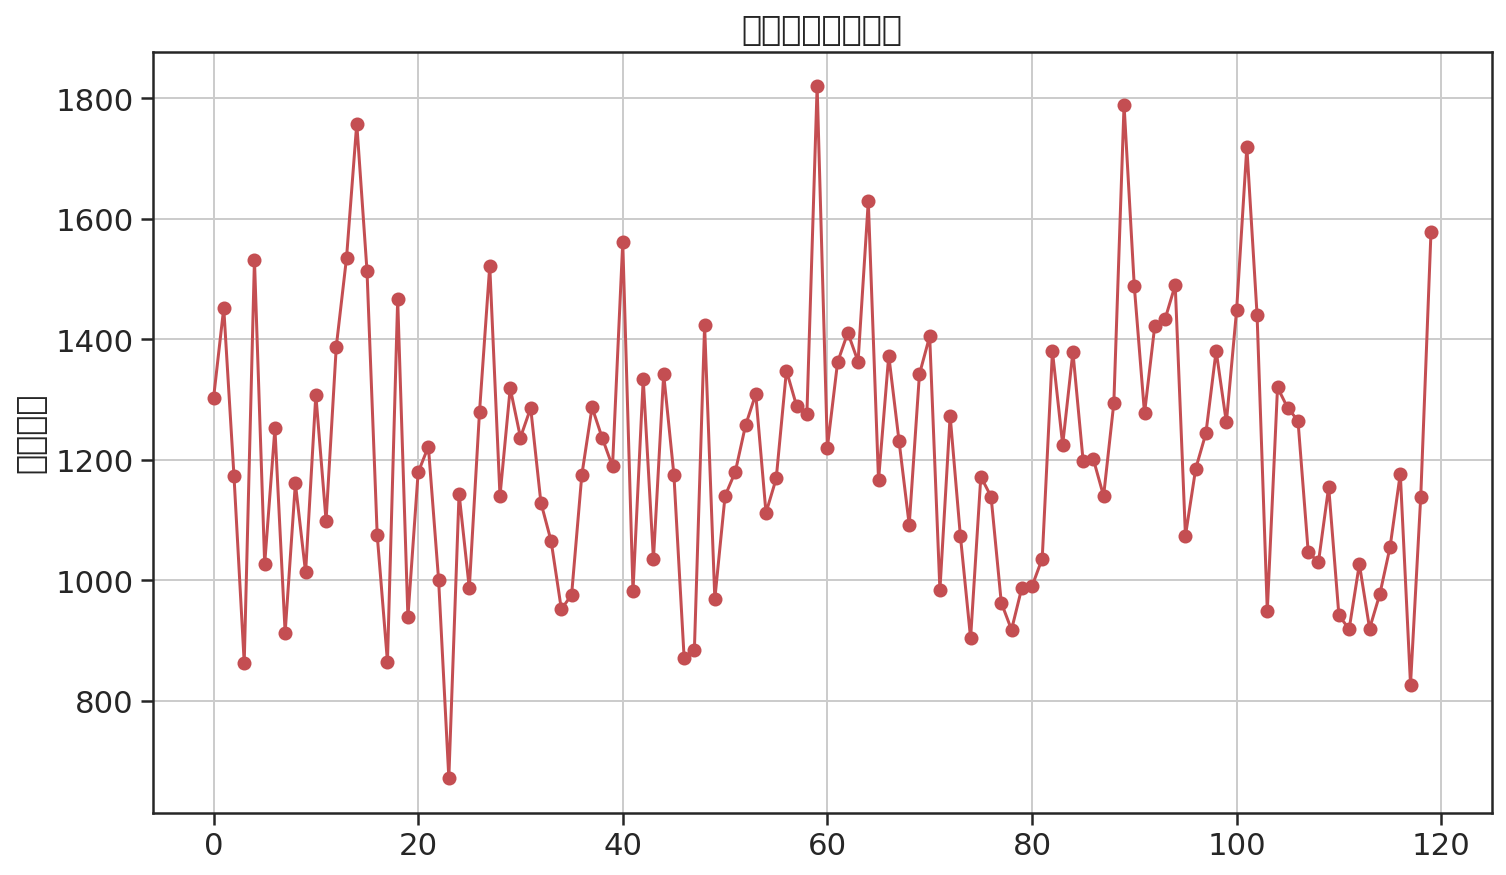

In [24]:
## 可视化每个章节获得的关键词数量
TK_df.cutword.apply(len).plot(kind = "line",figsize=(12,7),
                              style = "r-o")
plt.grid()
plt.title("每章节的词语数量")
plt.ylabel("词语数量")
plt.show()

In [25]:
## 查看全文的分词结果
TK_df.cutword[0:5]

0    [滚滚, 长江, 江东, 逝水, 浪花, 英雄, 是非, 是非成败, 成败, 转头, 青山,...
1    [董卓, 仲颖, 陇西, 西临, 临洮, 官拜, 河东, 太守, 自来, 骄傲, 当日, 怠...
2    [曹操, 当日, 何进, 宦官, 古今, 不当, 于此, 治罪, 元恶, 狱吏, 足矣, 纷...
3    [董卓, 董卓欲, 袁绍, 李儒, 袁绍, 手提, 宝剑, 辞别, 百官, 东门, 冀州, ...
4    [却说, 陈宫, 下手, 曹操, 转念, 念曰, 国家, 不义, 上马, 不等, 天明, 自...
Name: cutword, dtype: object

In [26]:
## 连接切分后的词语
cutwords = np.concatenate(TK_df.cutword)
## 计算每个词出现的频率
word, counts = np.unique(cutwords,return_counts = True)
word_fre = dict(zip(word, counts))  # 词语和出现次数定义为字典
## 可视化分词后的词云
plt.figure(figsize=(16,10))
## 设置词云参数
WordC = WordCloud(font_path="/Library/Fonts/Microsoft/Kaiti.ttf",
                  margin=1,width=1800, height=1200,
                  max_words=800, min_font_size=10, 
                  background_color="white",max_font_size=200,)
## 从文本数据中可视化词云
WordC.generate_from_frequencies(word_fre)
plt.imshow(WordC)
plt.axis("off")
plt.title("《三国演义》")
plt.show()  

OSError: ignored

<Figure size 1152x720 with 0 Axes>

####  11.4.1 文本数据特征获取

#### n-gram模型（词袋模型）获取TF-IDF特征

In [28]:
TK_df.head()

Name                                            content  \
0  宴桃园豪杰三结义,斩黄巾英雄首立功  滚滚长江东逝水，浪花淘尽英雄。是非成败转头空。青山依旧在，几度夕阳红。白发渔樵江渚上，惯看秋...   
1    张翼德怒鞭督邮,何国舅谋诛宦竖  且说董卓字仲颖，陇西临洮人也，官拜河东太守，自来骄傲。当日怠慢了玄德，张飞性发，便欲杀之。玄...   
2  议温明董卓叱丁原,馈金珠李肃说吕布  且说曹操当日对何进曰：“宦官之祸，古今皆有；但世主不当假之权宠，使至于此。若欲治罪，当除元恶...   
3    废汉帝陈留践位,谋董贼孟德献刀  且说董卓欲杀袁绍，李儒止之曰：“事未可定，不可妄杀。”袁绍手提宝剑，辞别百官而出，悬节东门，...   
4  发矫诏诸镇应曹公,破关兵三英战吕布  却说陈宫临欲下手杀曹操，忽转念曰：“我为国家跟他到此，杀之不义。不若弃而他往。”插剑上马，不...   

                                             cutword  
0  [滚滚, 长江, 江东, 逝水, 浪花, 英雄, 是非, 是非成败, 成败, 转头, 青山,...  
1  [董卓, 仲颖, 陇西, 西临, 临洮, 官拜, 河东, 太守, 自来, 骄傲, 当日, 怠...  
2  [曹操, 当日, 何进, 宦官, 古今, 不当, 于此, 治罪, 元恶, 狱吏, 足矣, 纷...  
3  [董卓, 董卓欲, 袁绍, 李儒, 袁绍, 手提, 宝剑, 辞别, 百官, 东门, 冀州, ...  
4  [却说, 陈宫, 下手, 曹操, 转念, 念曰, 国家, 不义, 上马, 不等, 天明, 自...

In [29]:
## 针对中文数据 使用n-gram模型获取数据的特征

## 准备工作，将分词后的结果整理成，CountVectorizer（）可应用的形式
## 将所有分词后的结果使用空格连接为字符串，并组成列表，每一段为列表中的一个元素
articals = []
for cutword in TK_df.cutword:
    cutword = [s for s in cutword if len(s) < 6]
    cutword = " ".join(cutword)
    articals.append(cutword)

In [30]:
## 构建语料库，并计算文档－－词的TF－IDF矩阵
vectorizer = CountVectorizer(max_features=2000,  #使用的词组数量
                             ngram_range=(1, 2)) #可以使用1个或者两个词语组成词组  
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(vectorizer.fit_transform(articals))
tfidf_array = tfidf.toarray()
print("文档--词的TF-IDF矩阵维度为:",tfidf_array.shape)

文档--词的TF-IDF矩阵维度为: (120, 2000)


In [31]:
## 针对英文数据获取使用Doc2Vec模型获得每个句子的特征
textdf.head()

NameError: ignored

In [32]:
# gemsim里Doc2vec模型需要的输入格式为[句子，句子序号]的样本
documents = [TaggedDocument(text.split(" "), [ii]) for ii, text in enumerate(textdf.text_pre)]
# 初始化和训练模型
model = Doc2Vec(documents, vector_size=500, ## 获取特征向量的维度
                dm=1,  ## 指定使用的算法，1:PV-DM；0:PV-DBOW；
                window=5,  ## 句子中当前词和预测词之间的最大距离
                min_count=5, ## 使用词语的最小词频
                epochs=50)   ## 迭代训练的轮数
model.train(documents,total_examples=model.corpus_count,epochs=model.epochs)
# 获得数据集中每个句子的句向量
documents_vecs = np.array([model.docvecs[sen.tags[0]] for sen in documents])
print("documents_vecs.shape:",documents_vecs.shape)

NameError: ignored

#### 11.4.2 常用的聚类算法

#### 系统聚类

In [ ]:
#### 11.4.2 常用的聚类算法

#### 系统聚类

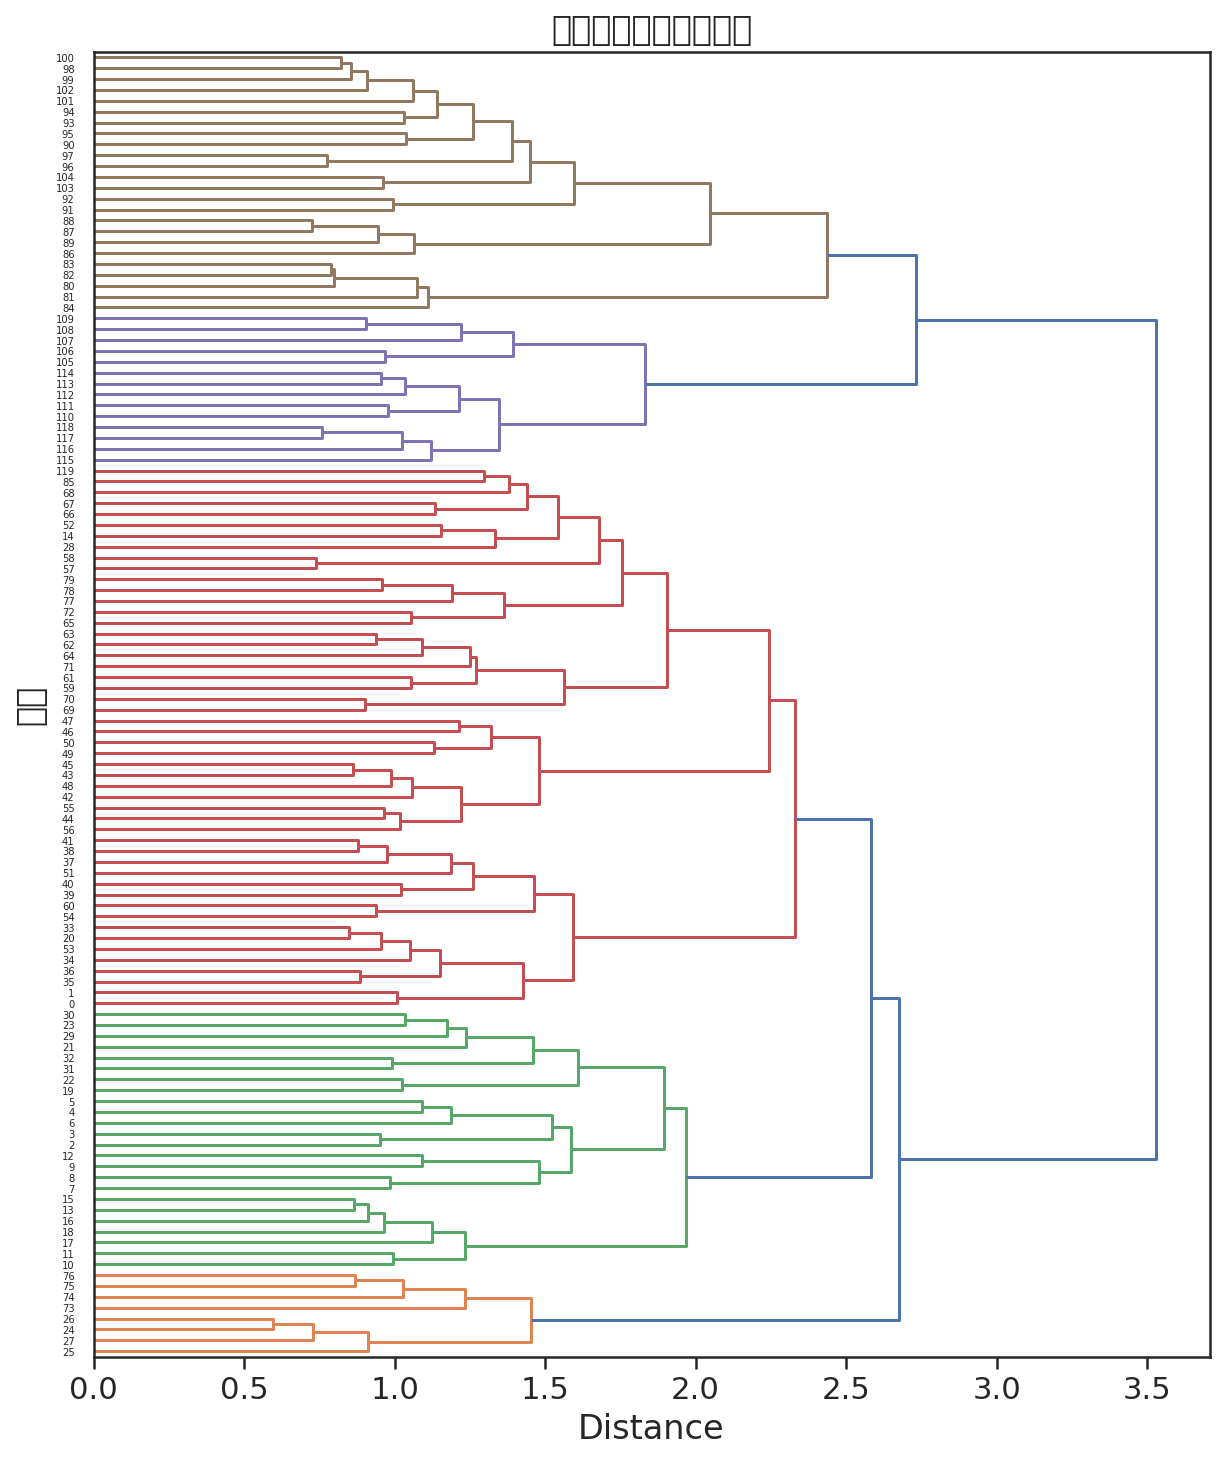

In [33]:
## 对数据进行系统聚类
Z = linkage(tfidf_array, method='ward', metric='euclidean')
fig = plt.figure(figsize=(10,12))
reddn = dendrogram(Z,orientation='right')
plt.title("《三国演义》层次聚类")
plt.ylabel("章节")
plt.xlabel("Distance")
plt.show()

## 可以发现该数据可以聚类为5类

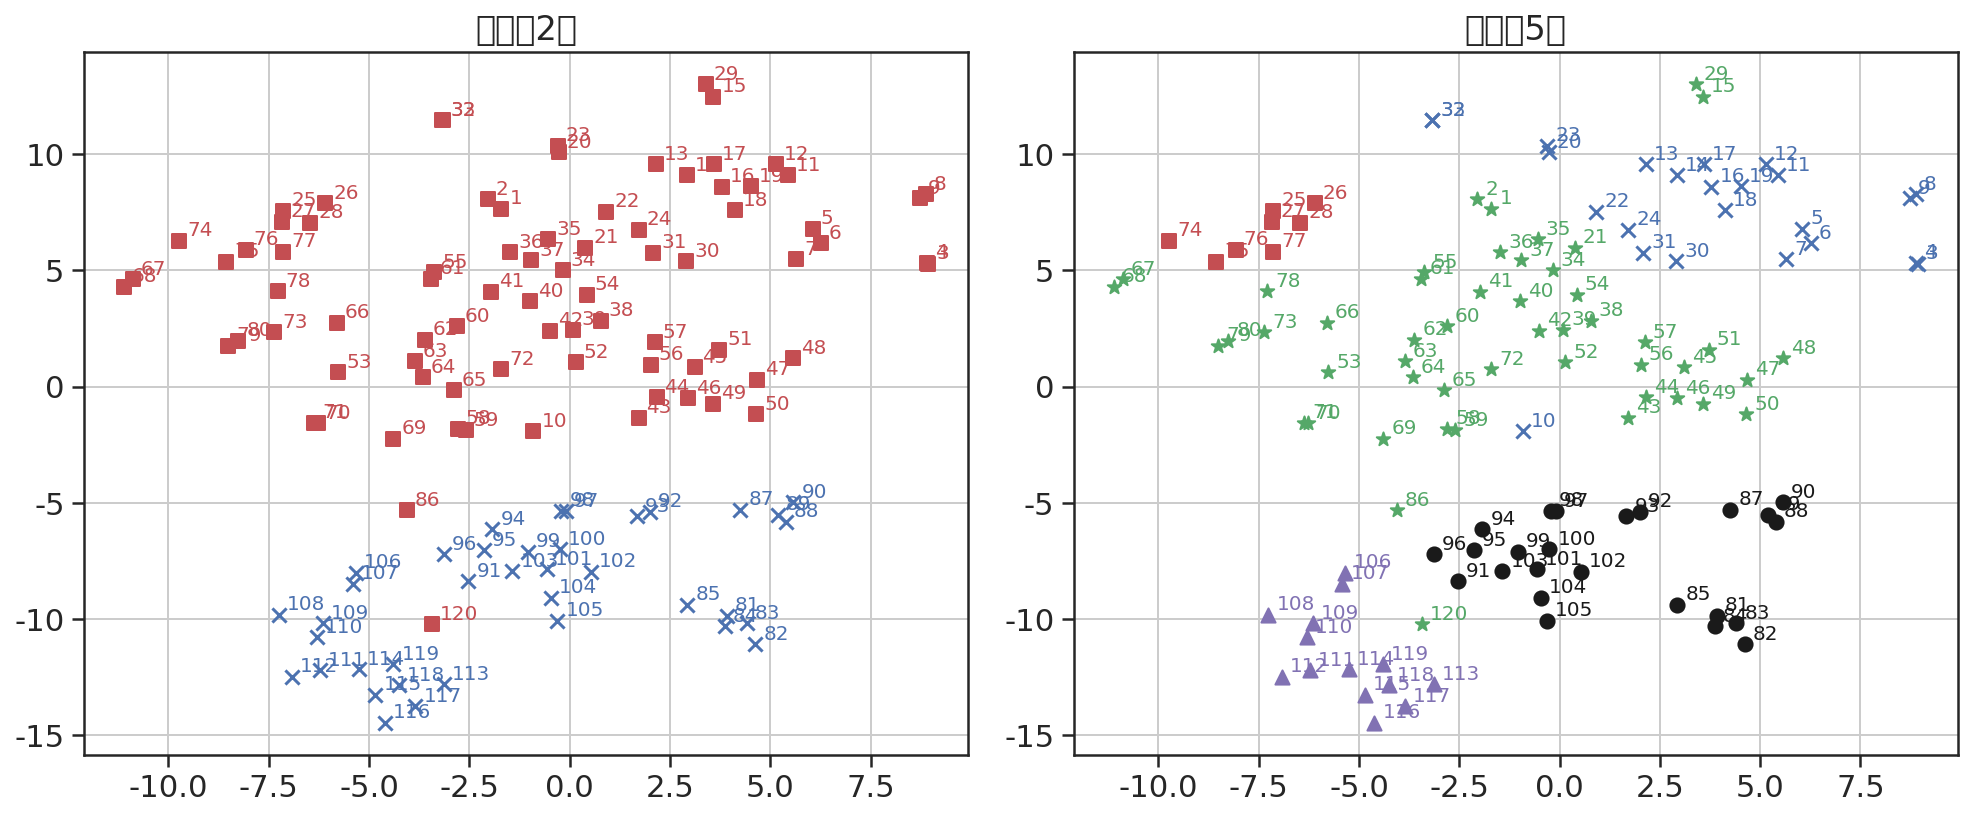

In [34]:
## 获取每个章节的类别标签
clu2 = fcluster(Z,t = 2, criterion="maxclust") # 聚类为2簇
clu5 = fcluster(Z,t = 5, criterion="maxclust") # 聚类为5簇

## 将数据特征降维到2维空间
tsne = TSNE(n_components=2, random_state=1233)
tfidf_tsne = tsne.fit_transform(tfidf_array)

## 可视化每个章节在空间中的分布与聚集情况
shape = ["s","x","*","^","o"]
color = ["r","b","g","m","k",]
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
for ii in range(120):
    cla = clu2[ii]-1   # 簇的标签
    plt.scatter(tfidf_tsne[ii,0],tfidf_tsne[ii,1],
                c=color[cla],marker = shape[cla],s = 50)
    plt.text(tfidf_tsne[ii,0]+0.2,tfidf_tsne[ii,1]+0.2,
             str(ii+1),size = 10,c = color[cla])
plt.grid()
plt.title("聚类为2簇")

plt.subplot(1,2,2)
for ii in range(120):
    cla = clu5[ii]-1  # 簇的标签
    plt.scatter(tfidf_tsne[ii,0],tfidf_tsne[ii,1],
                c=color[cla],marker = shape[cla],s = 50)
    plt.text(tfidf_tsne[ii,0]+0.2,tfidf_tsne[ii,1]+0.2,
             str(ii+1),size = 10,c = color[cla])
plt.title("聚类为5簇")
plt.grid()
plt.tight_layout()
plt.show()

### 11.5 《三国演义》人物关系分析

#### 11.5.1 任务重要性时序分析

In [35]:
!cp /content/drive/MyDrive/Colab/data/一些三国人物的名和字.csv /content

In [37]:
## 读取三国一些三国人物的名和字数据
TK_name = pd.read_csv("一些三国人物的名和字.csv")
print(TK_name.head())

     名   字  阵营
0   曹操  孟德  曹魏
1   曹丕  子桓  曹魏
2  司马懿  仲达  曹魏
3   荀彧  文若  曹魏
4   荀攸  公达  曹魏


In [38]:
## 计算一个人物名称在每个章节出现的次数
TK_name_time = []
for ii in np.arange(len(TK_name)):
    times = []
    name = TK_name.iloc[ii,0]  # 获取要计算的字
    zi = TK_name.iloc[ii,1]    # 获取要计算的名
    nametime = TK_df.content.apply(func = lambda x: x.count(name))
    zitime = TK_df.content.apply(func = lambda x: x.count(zi) if pd.isnull(zi)== False else 0)
    times = nametime.values + zitime.values
    TK_name_time.append(times)
## 计算结果设计为数据表
TK_name_timedf = pd.DataFrame(data = np.array(TK_name_time).T,
                              columns = TK_name.iloc[:,0])
TK_name_timedf

名    曹操  曹丕  司马懿  荀彧  荀攸  郭嘉  程昱  张辽  徐晃  夏侯惇  ...  何进  董卓  袁绍  吕布  袁术  刘表  \
0     2   0    0   0   0   0   0   0   0    0  ...   2   5   0   0   0   0   
1     5   0    0   0   1   0   0   0   0    0  ...  17   3   6   0   0   0   
2     7   0    0   0   0   0   0   0   0    0  ...  13  15  14  11   3   0   
3    23   0    0   0   0   0   0   0   0    0  ...   1  18   6   5   0   0   
4    14   0    0   0   0   0   0   0   0    2  ...   0  13  11  35   8   0   
..   ..  ..  ...  ..  ..  ..  ..  ..  ..  ...  ...  ..  ..  ..  ..  ..  ..   
115   0   0    0   0   0   0   0   0   0    0  ...   0   0   0   0   0   0   
116   0   0    0   0   0   0   0   0   0    0  ...   0   0   0   0   0   0   
117   0   0    0   0   0   0   0   0   0    0  ...   0   0   0   0   0   0   
118   3   3    3   0   0   0   0   0   0    0  ...   0   0   0   0   0   0   
119   1   0    0   0   0   0   0   0   0    0  ...   1   1   1   0   1   1   

名    刘璋  马腾  张鲁  韩遂  
0     0   0   0   0  
1     0   0   0   0  
2     0   0   0   0  
3     0   0   0   0  
4     0   1   0   0  
..   ..  ..  ..  ..  
115   0   0   0   0  
116   1   0   0   0  
117   0   0   0   0  
118   0   0   0   0  
119   0   1   1   1  

[120 rows x 56 columns]

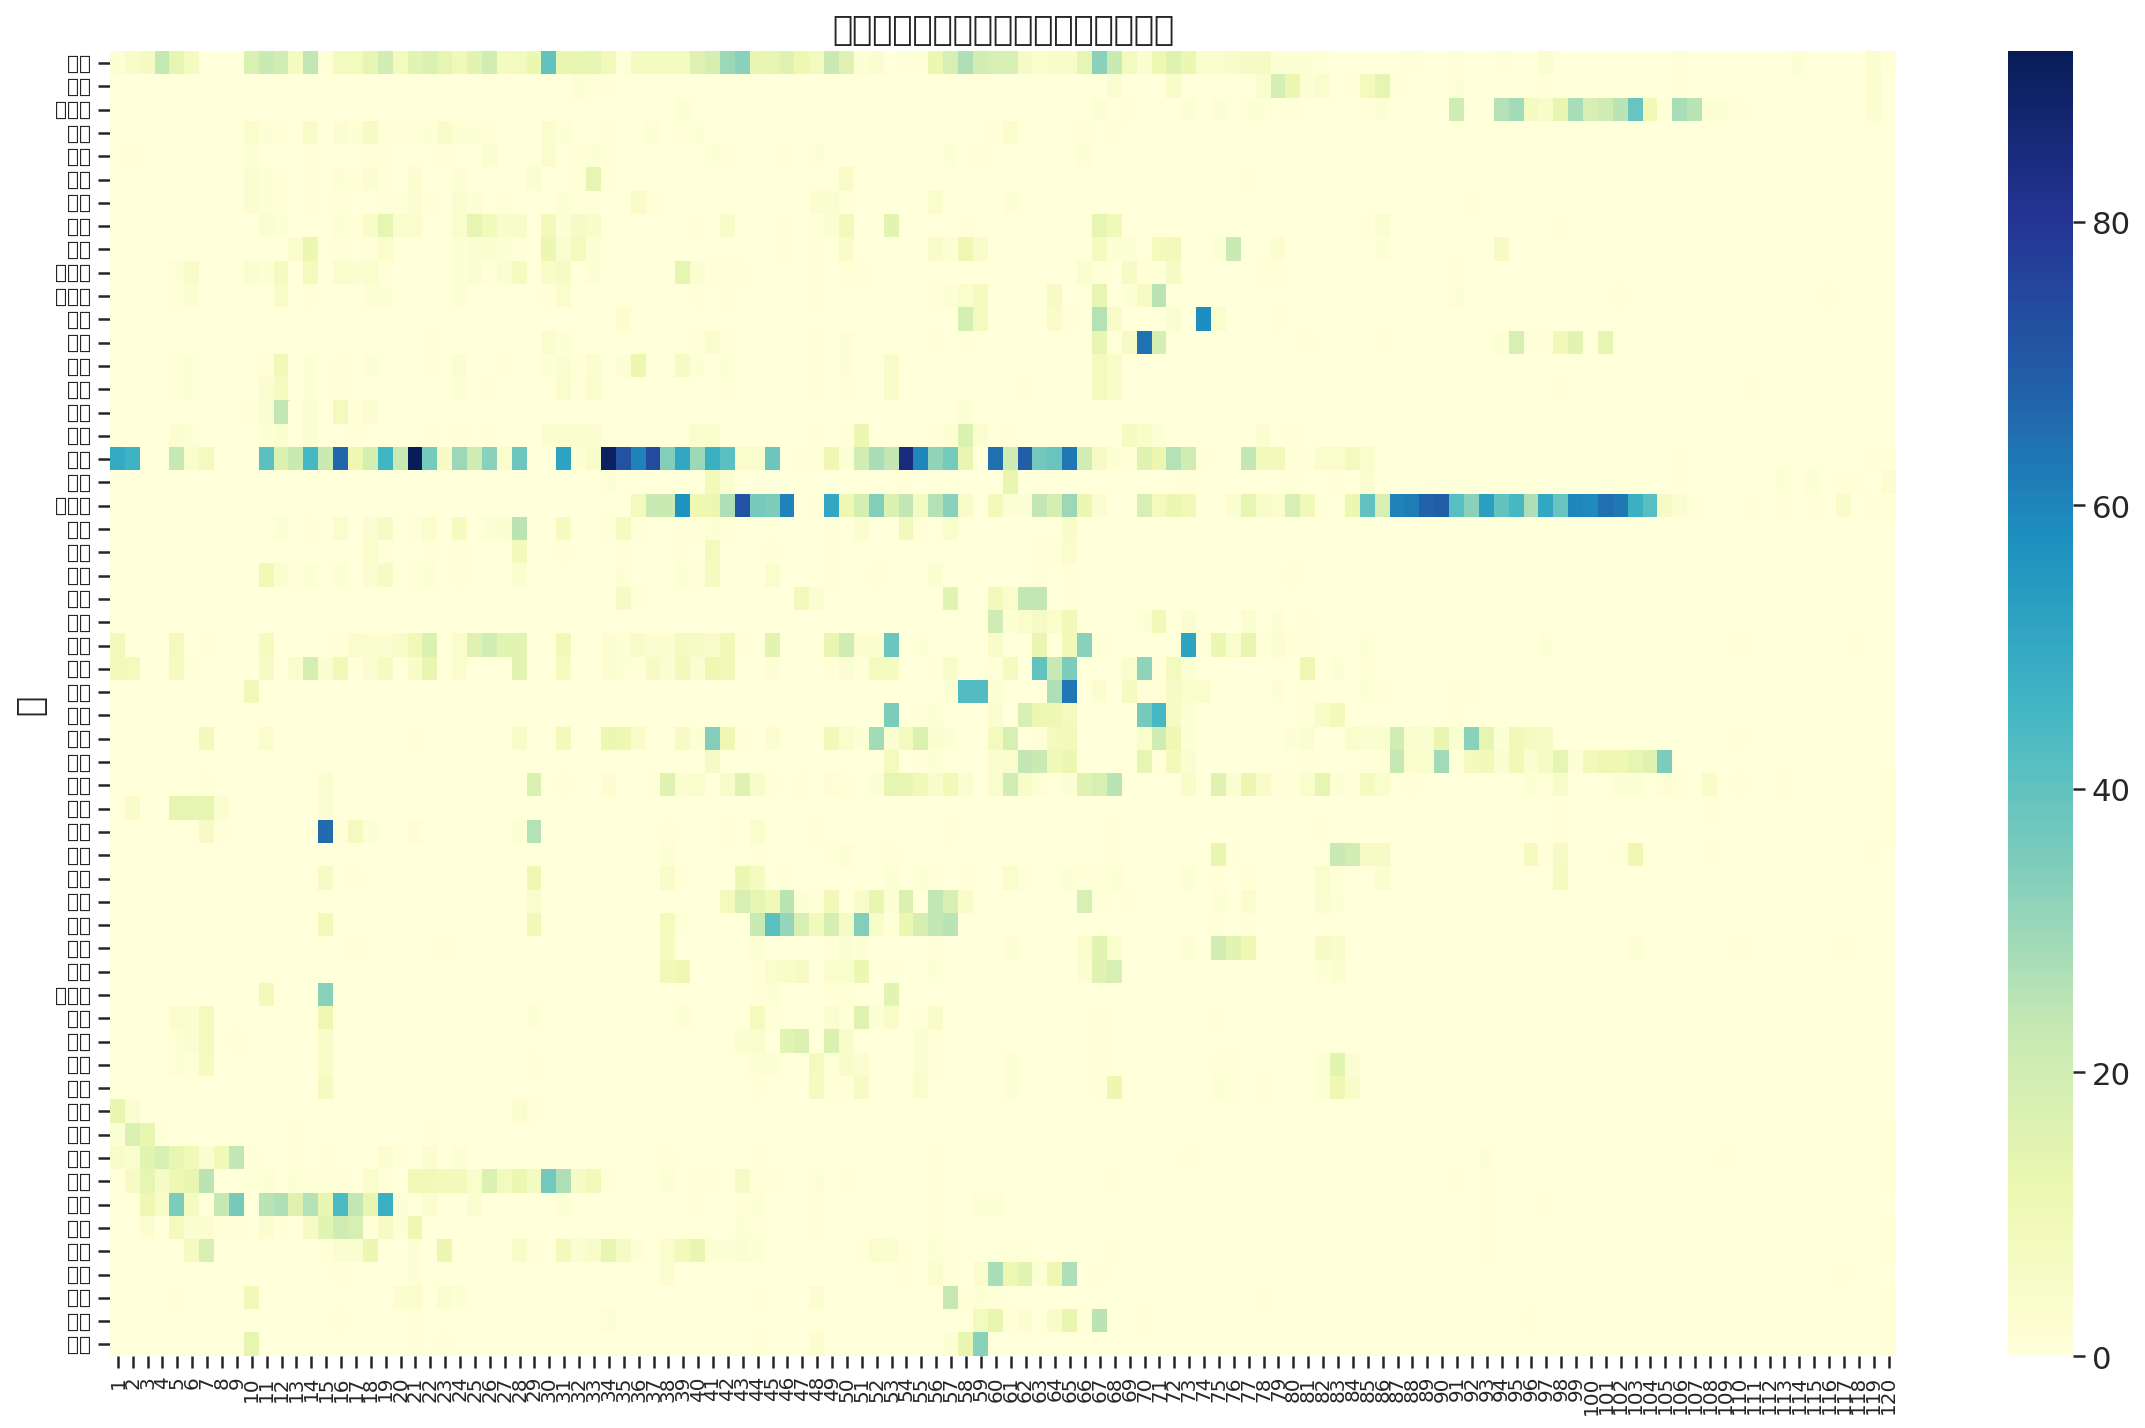

In [39]:
## 使用热力图可视化每个人出现的次数
plt.figure(figsize=(20,12))
ax = sns.heatmap(TK_name_timedf.T,annot=False,cmap="YlGnBu",
                 yticklabels=True,xticklabels=True)
ax.set_yticklabels(TK_name_timedf.columns, fontsize = 10)
ax.set_xticklabels(TK_name_timedf.index+1, fontsize = 10)
plt.title("三国演义中每个人在各章节的出现次数")
plt.show()

In [40]:
## 使用蒸汽图可视化一些重要人物的出场情况
plotname = ["曹操","曹丕","刘备","刘禅","孙策","孙权"]
plotdata = TK_name_timedf[plotname]
plotdata["chap"] = np.arange(1,121)
## 转化为长数据
plotdata = plotdata.melt(["chap"], var_name="name",value_name="value")
plotdata
## 使用可交互蒸汽图可视化
selection = alt.selection_multi(fields=["name"], bind="legend")

alt.Chart(plotdata).mark_area().encode(
    alt.X("chap:Q"),                              ## X轴
    alt.Y("value:Q", stack="center",axis=None), ## Y轴
    alt.Color("name:N",scale=alt.Scale(scheme="category20c")), ## 设置颜色
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
).properties(width=800,height=400).add_selection(selection) 

alt.Chart(...)

#### 11.5.2 人物关系可视化分析

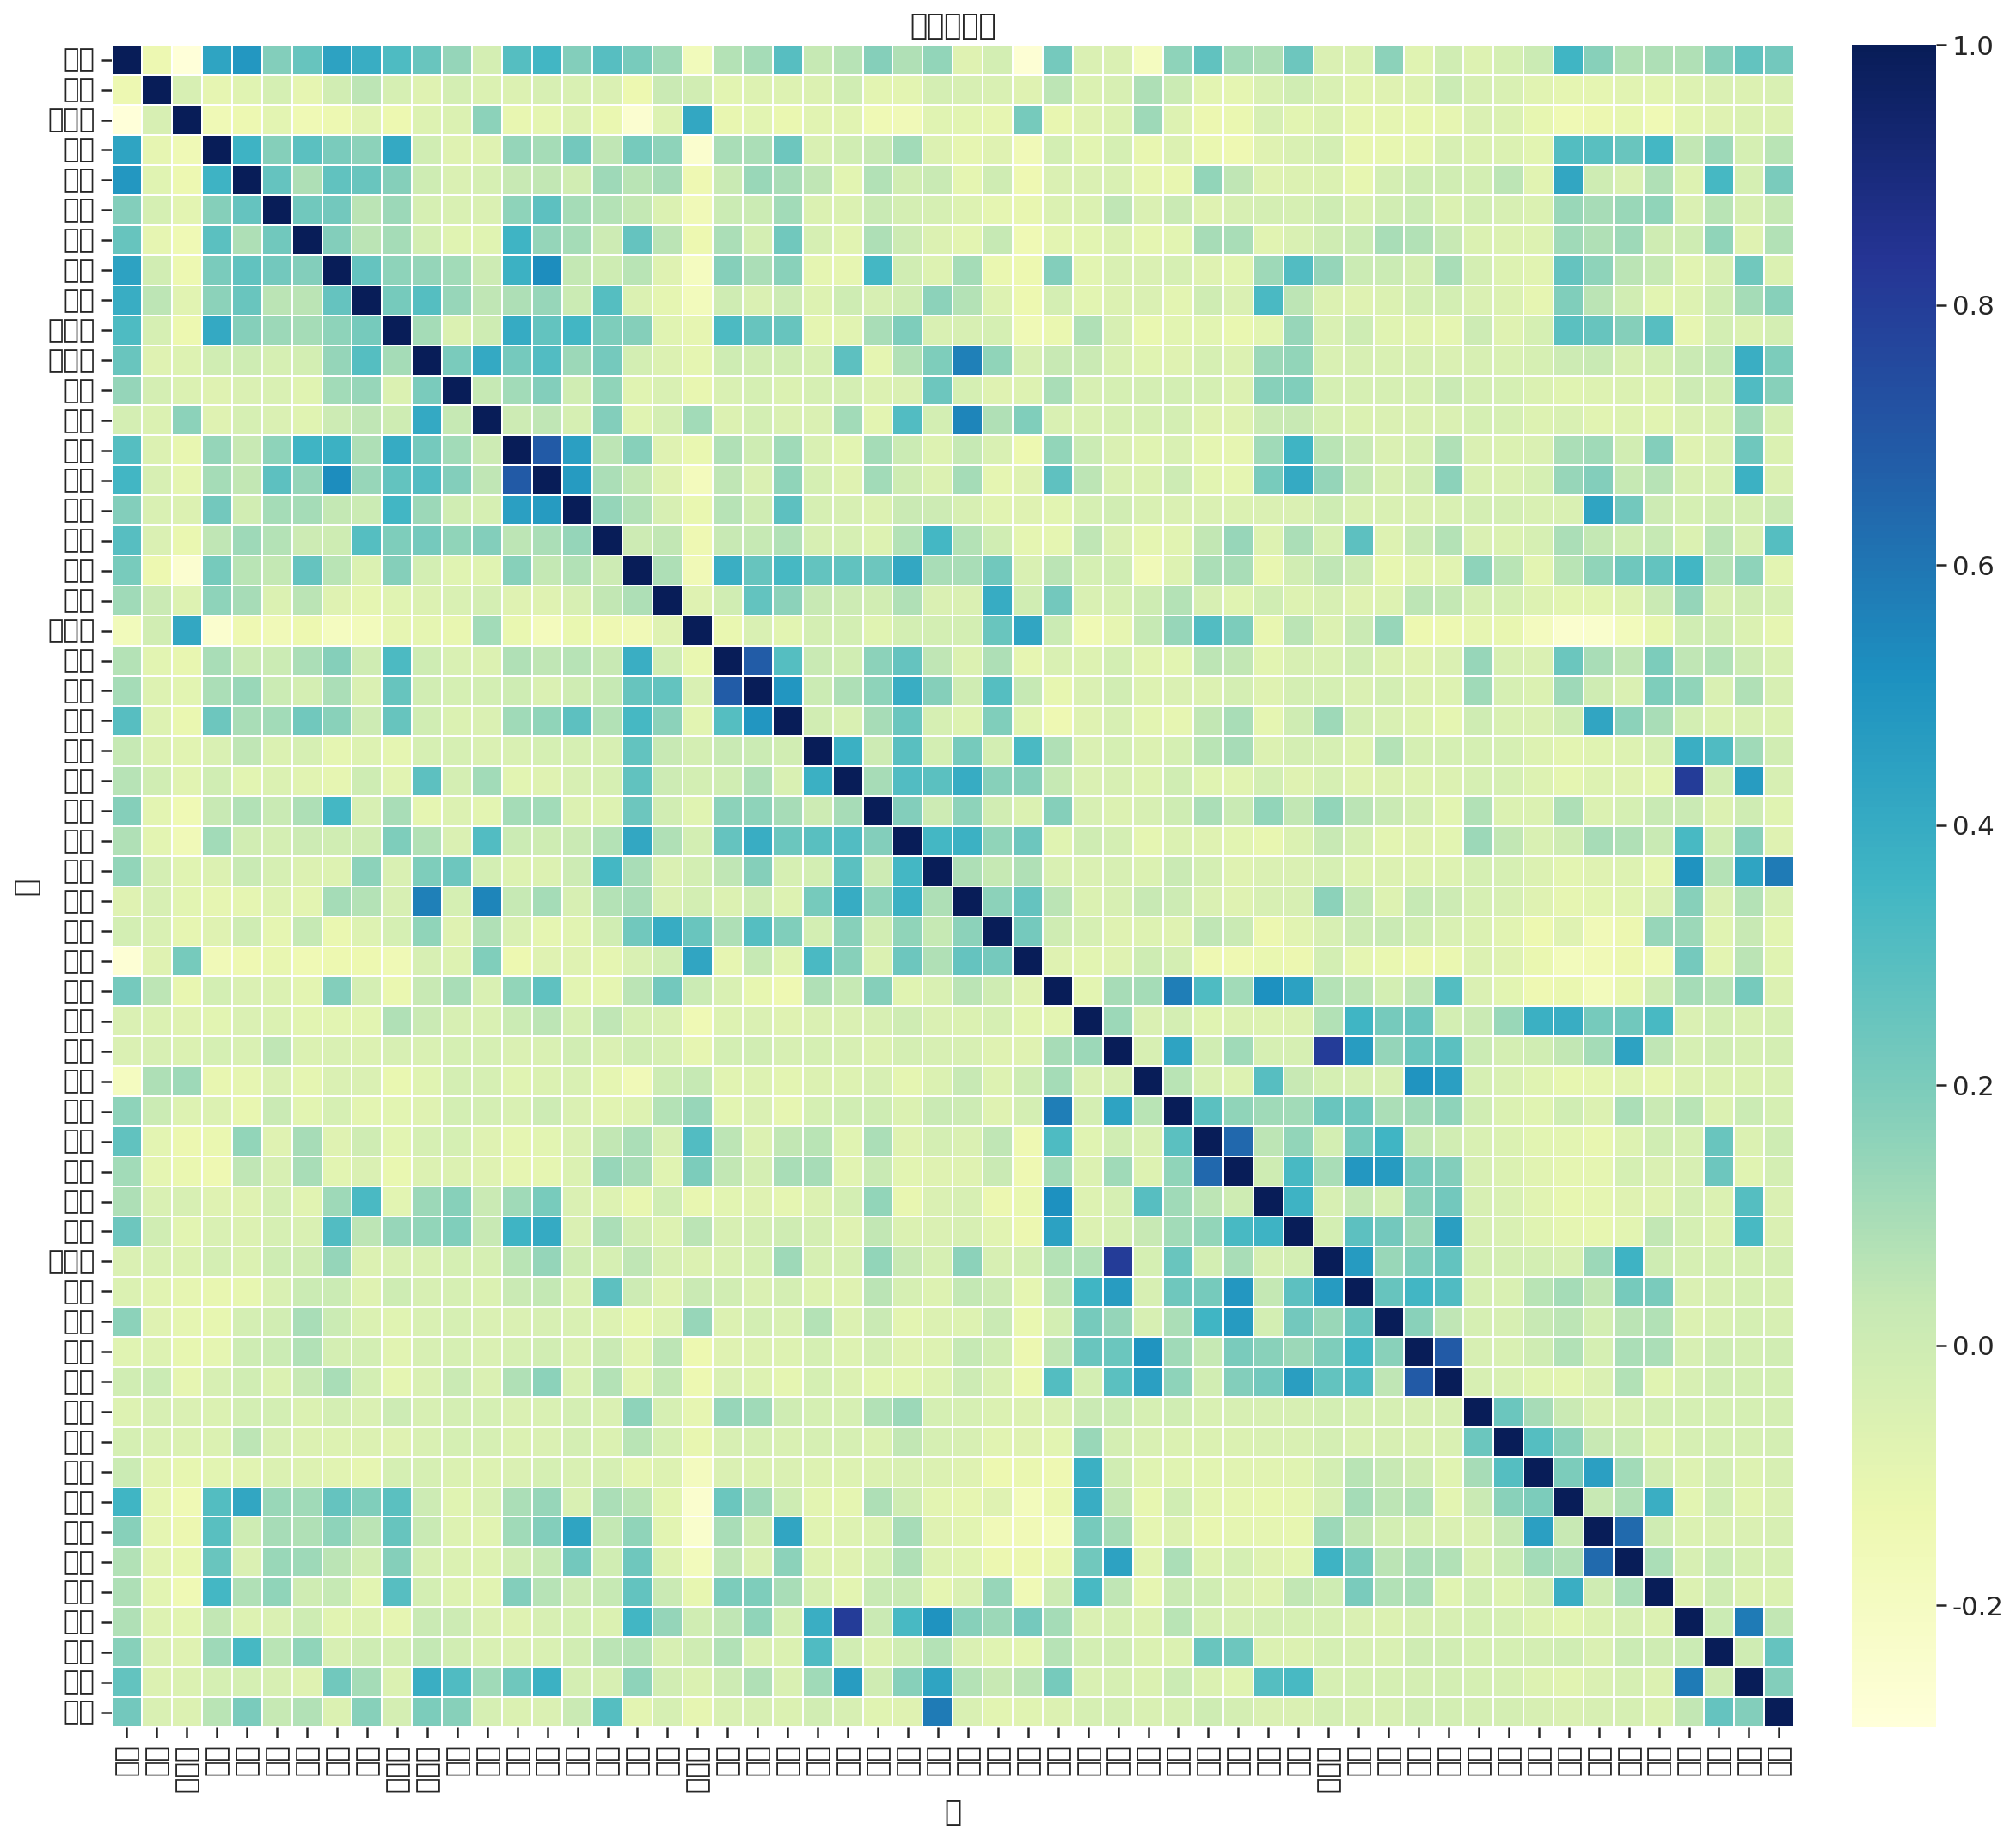

In [41]:
## 根据人物的出场情况计算他们之间的相关系数
Tkcor = TK_name_timedf.corr(method="pearson")
## 相关系数热力图
plt.figure(figsize=(20,18))
ax = sns.heatmap(Tkcor,square=True,annot=False,
                 linewidths=.5,cmap="YlGnBu",
                 cbar_kws={"fraction":0.046, "pad":0.03},
                 yticklabels=True,xticklabels=True)
ax.set_title("人物相关性")
plt.show()

In [42]:
## 根据出场的相关系数大小，构建人物之间的网络
## 相关系数矩阵的下三角取值定义为NaN
Tkcor = Tkcor.where(np.triu(np.ones(Tkcor.shape),k = 1).astype(np.bool))
## 宽数据转化为长数据
Tkcor.columns.name = "start"
Tkcor.index.name = "end"
Tkcorlong = Tkcor.unstack().reset_index()
Tkcorlong.columns = ["start","end","weight"]
## 剔除NaN的数据
Tkcorlong = Tkcorlong[~Tkcorlong["weight"].isna()]
## 去除相关系数的绝对值小于0.3的数据
Tkcorlong = Tkcorlong[Tkcorlong["weight"] > 0.3]
Tkcorlong = Tkcorlong.reset_index(drop = True)
print("Tkcorlong.shape",Tkcorlong.shape)

Tkcorlong.shape (100, 3)


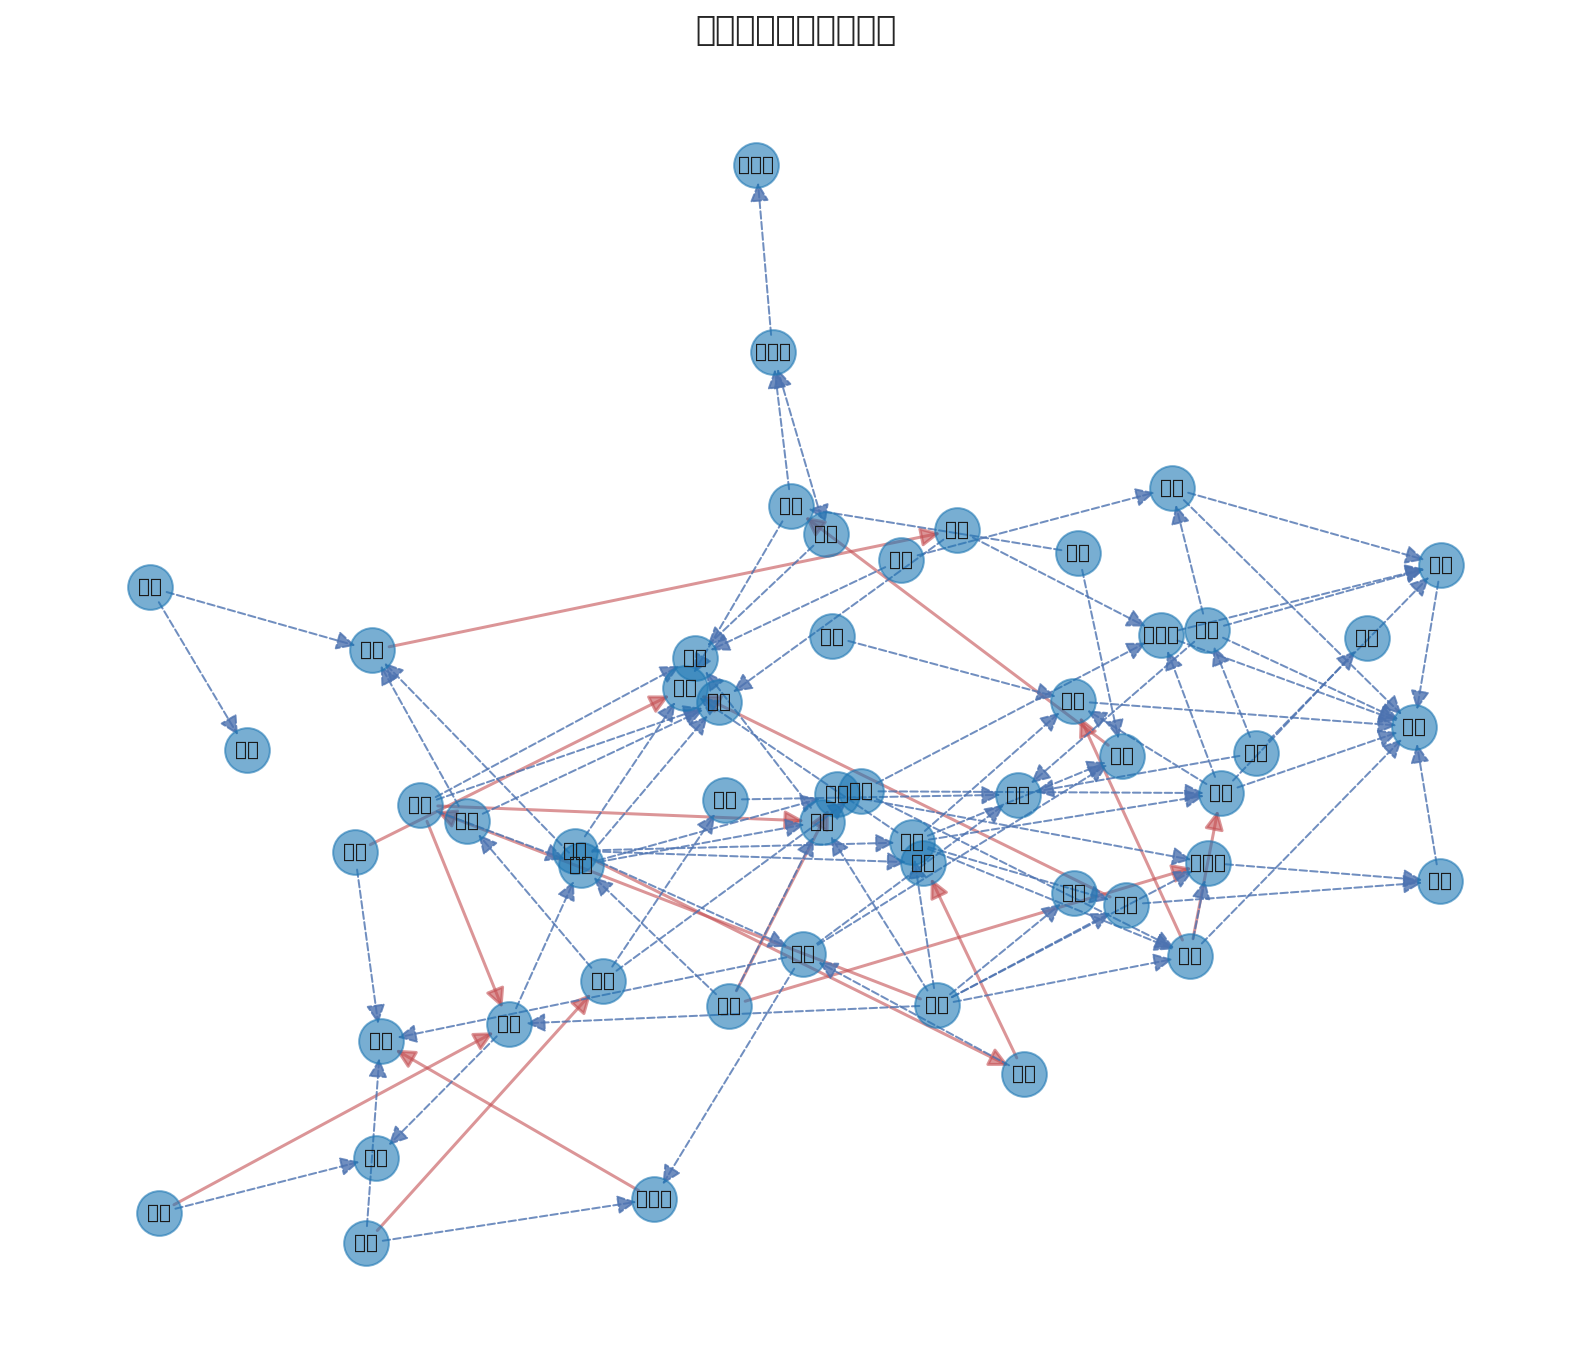

In [43]:
## 使用有向图可视化人物之间的关系
plt.figure(figsize=(14,12))
## 生成社交网络图
G=nx.DiGraph()

## 添加边
for ii in Tkcorlong.index:
    G.add_edge(Tkcorlong.start[ii],Tkcorlong.end[ii],weight = Tkcorlong.weight[ii])
    
## 定义两种边
big=[(u,v) for (u,v,d) in G.edges(data=True) if d["weight"] >0.5]
small=[(u,v) for (u,v,d) in G.edges(data=True) if d["weight"] <0.5]

## 图的布局
pos=nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G,pos,alpha=0.6,node_size=500)
nx.draw_networkx_edges(G,pos,edgelist=big,
                       width=1.5,alpha=0.6,edge_color="r",arrowsize=20)
nx.draw_networkx_edges(G,pos,edgelist=small,
                       width=1,alpha=0.8,edge_color="b",arrowsize=20,style="dashed")
nx.draw_networkx_labels(G,pos,font_size=10,font_family = "Kaiti")

plt.axis("off")
plt.title("《三观演义》人物关系")
plt.show() 

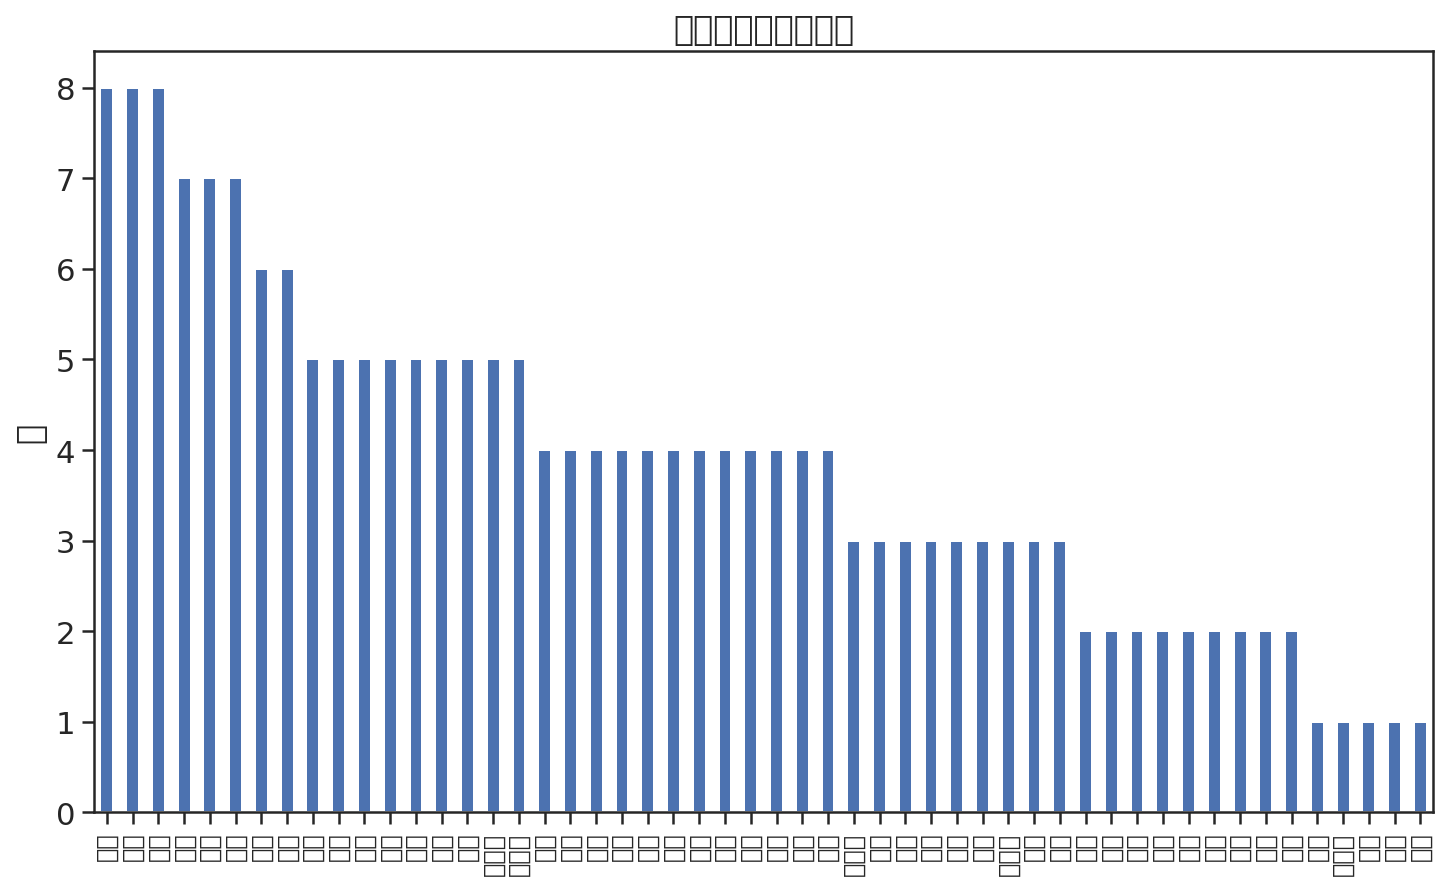

In [44]:
## 计算每个节点的度,分析人物的重要成程度
Tk_degree = pd.DataFrame(list(G.degree))
Tk_degree.columns = ["name","degree"]
Tk_degree = Tk_degree.sort_values(by="degree",ascending=False)
## 可视化
Tk_degree.plot(kind = "bar",x="name",y = "degree",
               figsize=(12,7),legend=False)
plt.xticks(size = 12)
plt.ylabel("度")
plt.xlabel("")
plt.title("有向图的节点度分布")
plt.show()

## 第一章 Python机器学习入门
沒有那麼快,學習需要時間,至少Code要可以run一套,才會比較容易保存.

### 1.3 Python语法介绍
#### 1.3.1 列表、元组和字典

#### 列表

列表（list）是一种有序的集合，可以随时添加和删除其中的元素。

In [46]:
## 生成一个列表
A = [1,2,3,4,5]
A

[1, 2, 3, 4, 5]

In [47]:
## 计算列表中原始的数量
len(A)

5

In [48]:
## 通过索引获取列表中的元素

## 从前往后时，索引从0开始
A[3]

4

In [49]:
## 从后往前时，索引从-1开始
A[-2]

4

In [50]:
## 获取列表中的一段
print(A[0:3])
print(A[1:-1])   # 输出的结果中不包含第3索引和第-1索引的元素

[1, 2, 3]
[2, 3, 4]


In [51]:
## 在列表的末尾添加新的元素
A.append(7)          ## 添加一个元素
A.append("eight")    ## 再添加一个元素
A

## 也可以添加字符串

[1, 2, 3, 4, 5, 7, 'eight']

In [52]:
## 在列表的指定位置添加新的元素
A.insert(5,"Name")
A

[1, 2, 3, 4, 5, 'Name', 7, 'eight']

In [53]:
## 通过del删除指定的元素
del A[2]
A

[1, 2, 4, 5, 'Name', 7, 'eight']

In [54]:
## 列表中的元素还可以是列表
B = ["A","B",A,[7,8]]
B

['A', 'B', [1, 2, 4, 5, 'Name', 7, 'eight'], [7, 8]]

In [55]:
## 获取列表中的第三个元素
B[2]

[1, 2, 4, 5, 'Name', 7, 'eight']

In [56]:
## 列表组合
[1,2,3] + [4,5,6]

[1, 2, 3, 4, 5, 6]

In [57]:
## 列表重复
[1,2,"three"] * 2

[1, 2, 'three', 1, 2, 'three']

In [58]:
## 输出列表A的内容
A = [15,2,31,10,12,9,2]
## 列表的逆序
A.reverse()
A

[2, 9, 12, 10, 31, 2, 15]

In [59]:
## 计算列表中元素出现的次数
A.count(2)

2

In [60]:
## 对列表进行排序
A.sort()
A

[2, 2, 9, 10, 12, 15, 31]

In [61]:
## 获取列表中的最大值和最小值
print("A最小值:",min(A))
print("A最大值:",max(A))

A最小值: 2
A最大值: 31


#### 元组

元组（tuple）和list非常类似，但是tuple一旦初始化就不能修改

In [63]:
## 初始化一个元祖
C = (1,2,3,4,5)
C

(1, 2, 3, 4, 5)

In [64]:
## 只有1个元素的元组定义时必须加一个逗号
C1 = (1,)
C1

(1,)

In [65]:
## 通过索引获取元组中的元素
print(C[1])
print(C[-1])
print(C[1:5])

2
5
(2, 3, 4, 5)


In [66]:
## 输出元组中元素的个数
len(C)

5

In [67]:
## 将元组进行组合获得新的元组
D = C + ("A","B","C")
D

(1, 2, 3, 4, 5, 'A', 'B', 'C')

In [68]:
## 可以通过del删除整个元组
del C1
## C1    #这是C已经被删除，无法输出C

In [69]:
## 元组定义是可以重复
(1,2,"A","B") * 2

(1, 2, 'A', 'B', 1, 2, 'A', 'B')

In [70]:
## 获取元组中的最大值和最小值
print("C最小值:",min(C))
print("C最大值:",max(C))

C最小值: 1
C最大值: 5


#### 字典

字典的每个键值 key=>value 对用冒号 : 分割，每个键值对之间用逗号 , 分割，整个字典包括在花括号 {} 中

In [71]:
##  初始化一个字典
D = {"A":1, "B":2,"C":3,"D":4,"E":5}
D

{'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}

In [72]:
## 查看字典中的键key
D.keys()

dict_keys(['A', 'B', 'C', 'D', 'E'])

In [73]:
## 查看字典中的值value
D.values()

dict_values([1, 2, 3, 4, 5])

In [74]:
## 通过字典中的键获取对应的值
print('D["B"]:',D["B"])
print('D["D"]:',D["D"])

D["B"]: 2
D["D"]: 4


In [75]:
## 通过get方法获取字典中的内容,如果没有对应元素则输出None
print('D.get("C"):',D.get("C"))
print('D.get("F"):',D.get("F"))

D.get("C"): 3
D.get("F"): None


In [76]:
## 使用pop(key)方法删除对应的键值对
D.pop("A")
D

{'B': 2, 'C': 3, 'D': 4, 'E': 5}

In [77]:
## 更新字典中的取值
D["B"] = 10
D

{'B': 10, 'C': 3, 'D': 4, 'E': 5}

In [78]:
## 往字典中添加新的内容
D["F"] = 11
D

{'B': 10, 'C': 3, 'D': 4, 'E': 5, 'F': 11}

In [79]:
## 计算字典中元素的数量
len(D)

5

#### 1.3.2 条件判断、循环和函数

#### 条件判断

In [80]:
## if 语句
A = 10
if A % 2 == 0:
    print("A是偶数")

A是偶数


In [81]:
## if  else 语句
A = 9
if A % 2 == 0:
    print("A是偶数")
else:
    print("A是奇数")

A是奇数


In [82]:
## elif 语句
A = 1
if A % 2 == 0:
    print("A能被2整除")
elif A % 3 == 0 :
    print("A能被3整除")
else:
    print("A不能被2、3整除")

A不能被2、3整除


#### 循环

In [83]:
## 通过循环计算1～100的累加和
A = range(1,101)  ## 生成1～100的向量
Asum = 0
for ii in A:
    Asum = Asum+ii
Asum

5050

In [84]:
## 使用while循环计算1～100的累加和
A = 100
Asum = 0
while A > 0:
    Asum = Asum + A
    A = A - 1
Asum

5050

In [85]:
## 通过break跳出循环
A = 100
Asum = 0
while A > 0:
    Asum = Asum + A
    ## 如果和大于2000跳出循环
    if Asum > 2000:
        break
    A = A - 1
    
print("Asum:",Asum)
print("A:",A)

Asum: 2047
A: 78


In [86]:
## 在列表中使用列表表达式
A = list(range(10))
## 只保留偶数
B = [ii for ii in A if ii % 2 == 0]
B

[0, 2, 4, 6, 8]

In [87]:
## 计数的次方运算
B = [ii**ii for ii in A if ii % 2 == 1]
B

[1, 27, 3125, 823543, 387420489]

#### 函数

In [88]:
## 定义一个计算1～x的累加和的函数
def sumx(x):
    x = range(1,x+1)  ## 生成1～x的向量
    xsum = 0
    for ii in x:
        xsum = xsum+ii
    return xsum

In [89]:
## 调用上面的函数
x = 200
sumx(x)

20100

In [90]:
## lambda函数,一个参数
f = lambda x: x**2
f(5)

25

In [91]:
## lambda函数,多个参数
f = lambda x,y,z: (x+y)*z
f(5,6,7)


## lambda函数（表达式）中，冒号前面是参数，可以有多个，用逗号分隔，冒号右边是需要返回的值。

77

### 1.4 Python基础库的使用
#### 1.4.1 Numpy库入门

In [92]:
import numpy as np

#### 数组生成

In [93]:
## 一个一维数组
A = np.array([1,2,3,4,5,6,7,8])
A

array([1, 2, 3, 4, 5, 6, 7, 8])

In [94]:
## 通过列表生成二维数组
A = np.array([[1,2,3,4],[5,6,7,8]])
A

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [95]:
## 查看数组的形状
A.shape

(2, 4)

In [96]:
## 查看数组的维度
A.ndim

2

In [97]:
## 使用其它函数生成数组
## 全零数组
np.zeros((2,4))   

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [98]:
## 全1数组
np.ones((2,3))

array([[1., 1., 1.],
       [1., 1., 1.]])

In [99]:
## 单位矩阵
np.eye(3,3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [100]:
## 指定数组的数据类型
A1 = np.array([[1,2,3,4],[5,6,7,8]],dtype = np.float64)
A2 = np.array([[1,2,3,4],[5,6,7,8]],dtype = np.float32)
A3 = np.array([[1,2,3,4],[5,6,7,8]],dtype = np.int32)
print("A1.dtype:",A1.dtype)
print("A2.dtype:",A2.dtype)
print("A3.dtype:",A3.dtype)

A1.dtype: float64
A2.dtype: float32
A3.dtype: int32


In [101]:
## 变换数据之间的数据类型
B1 = A1.astype(np.int32)
B2 = A2.astype(np.int8)
B3 = A3.astype(np.float32)
print("B1.dtype:",B1.dtype)
print("B2.dtype:",B2.dtype)
print("B3.dtype:",B3.dtype)

B1.dtype: int32
B2.dtype: int8
B3.dtype: float32


#### 数组中的索引

基本索引、切片索引、布尔索引

In [102]:
## 通过索引获取数组中的元素
A = np.arange(12).reshape(3,4)
A

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [103]:
## 获取数组中的某个元素
A[1,1]

5

In [104]:
## 对数组中的某个元素重新赋值
A[1,1] = 100
A

array([[  0,   1,   2,   3],
       [  4, 100,   6,   7],
       [  8,   9,  10,  11]])

In [105]:
## 获取数组中的某行
A[1,:]

array([  4, 100,   6,   7])

In [106]:
## 获取数组中的某列
A[:,1]

array([  1, 100,   9])

In [107]:
## 获取数组中的某部分
A[0:2,1:4]

array([[  1,   2,   3],
       [100,   6,   7]])

In [108]:
## 根据布尔值进行索引
index = A % 2 == 1
index

array([[False,  True, False,  True],
       [False, False, False,  True],
       [False,  True, False,  True]])

In [109]:
## 根据index获取数组中的奇数
A[index]

array([ 1,  3,  7,  9, 11])

In [110]:
## 不使用中间结果的方式
A[A % 2 == 1]

array([ 1,  3,  7,  9, 11])

In [111]:
## 通过np.where找到符合条件的值
a,b = np.where(A % 2 == 1)
print("行索引:",a)
print("列索引:",b)
print("数组中的奇数:",A[a,b])

行索引: [0 0 1 2 2]
列索引: [1 3 3 1 3]
数组中的奇数: [ 1  3  7  9 11]


In [112]:
## A中如果是奇数就正常输出，否则就输出对应数值的10倍
np.where(A % 2 == 1, A, 10*A)

array([[   0,    1,   20,    3],
       [  40, 1000,   60,    7],
       [  80,    9,  100,   11]])

In [113]:
## 数组的转置
A.T

array([[  0,   4,   8],
       [  1, 100,   9],
       [  2,   6,  10],
       [  3,   7,  11]])

In [114]:
## 数组的轴转换
B = np.arange(24).reshape(3,4,2)
print("B.shape:",B.shape)
C = B.transpose((2,1,0))
print("C.shape",C.shape)

B.shape: (3, 4, 2)
C.shape (2, 4, 3)


#### 数组中的一些运算函数

In [115]:
A = np.arange(12).reshape(3,4)
A

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [116]:
## 计算均值
print("数组的均值:",A.mean())
print("数组每列的均值:",A.mean(axis = 0))
print("数组每行的均值:",A.mean(axis = 1))

数组的均值: 5.5
数组每列的均值: [4. 5. 6. 7.]
数组每行的均值: [1.5 5.5 9.5]


In [117]:
## 计算和
print("数组的和:",A.sum())
print("数组每列的和:",A.sum(axis = 0))
print("数组每行的和:",A.sum(axis = 1))

数组的和: 66
数组每列的和: [12 15 18 21]
数组每行的和: [ 6 22 38]


In [118]:
## 计算累加和
print("数组的累加和:\n",A.cumsum())
print("数组每列的累加和:\n",A.cumsum(axis = 0))
print("数组每行的累加和:\n",A.cumsum(axis = 1))

数组的累加和:
 [ 0  1  3  6 10 15 21 28 36 45 55 66]
数组每列的累加和:
 [[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]]
数组每行的累加和:
 [[ 0  1  3  6]
 [ 4  9 15 22]
 [ 8 17 27 38]]


In [119]:
## 计算标准差和方差
print("数组的标准差:",A.std())
print("数组每列的标准差:",A.std(axis = 0))
print("数组每行的标准差:",A.std(axis = 1))
print("数组的方差:",A.var())
print("数组每列的方差:",A.var(axis = 0))
print("数组每行的方差:",A.var(axis = 1))

数组的标准差: 3.452052529534663
数组每列的标准差: [3.26598632 3.26598632 3.26598632 3.26598632]
数组每行的标准差: [1.11803399 1.11803399 1.11803399]
数组的方差: 11.916666666666666
数组每列的方差: [10.66666667 10.66666667 10.66666667 10.66666667]
数组每行的方差: [1.25 1.25 1.25]


In [120]:
## 计算最大值和最小值
print("数组的最大值:",A.max())
print("数组每列的最大值:",A.max(axis = 0))
print("数组每行的最大值:",A.max(axis = 1))
print("数组的最小值:",A.min())
print("数组每列的最小值:",A.min(axis = 0))
print("数组每行的最小值:",A.min(axis = 1))

数组的最大值: 11
数组每列的最大值: [ 8  9 10 11]
数组每行的最大值: [ 3  7 11]
数组的最小值: 0
数组每列的最小值: [0 1 2 3]
数组每行的最小值: [0 4 8]


In [121]:
## 生成随机数
## 设置随机数种子
np.random.seed(11)

## 生成正态分布的随机数矩阵
np.random.randn(3,3)

array([[ 1.74945474, -0.286073  , -0.48456513],
       [-2.65331856, -0.00828463, -0.31963136],
       [-0.53662936,  0.31540267,  0.42105072]])

In [122]:
## 将0～10(不包括10)之间的数进行随机排序
np.random.seed(11)
np.random.permutation(10)

array([7, 8, 2, 6, 4, 5, 1, 3, 0, 9])

In [123]:
## 生成均匀分布的随机数矩阵
np.random.seed(11)
np.random.rand(2,3)

array([[0.18026969, 0.01947524, 0.46321853],
       [0.72493393, 0.4202036 , 0.4854271 ]])

In [124]:
## 在范围内生成随机数整数
np.random.seed(12)
np.random.randint(low = 2, high=10, size=15)

array([5, 5, 8, 7, 3, 4, 5, 5, 6, 2, 8, 3, 6, 7, 7])

In [125]:
## 数据的存储和导入

## 将数组保存为.npy文件
# np.save("data/chap1/Aarray.npy",A)
np.save("Aarray.npy",A)
## 导入数据文件A
B = np.load("Aarray.npy")
B

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [126]:
## 将多个数组保存为一个压缩文件
np.savez("ABarray.npz",x = A, y = B)

## 导入保存的数据
data = np.load("ABarray.npz")
# print('data["x"]:\n',data["x"])
print('data["y"]:\n',data["y"])

data["y"]:
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


#### 1.4.2 Pandas库入门

In [127]:
import pandas as pd

#### 序列和数据表

In [128]:
## 生成一个序列
s1 = pd.Series(data = [1,2,3,4,5],index = ["a","b","c","d","e"],
               name = "var1")
s1

a    1
b    2
c    3
d    4
e    5
Name: var1, dtype: int64

In [129]:
## 获取序列的数值和索引
print("数值:",s1.values)
print("索引:",s1.index)

数值: [1 2 3 4 5]
索引: Index(['a', 'b', 'c', 'd', 'e'], dtype='object')


In [130]:
## 通过索引获取序列中的内容
s1[["a","c"]]

a    1
c    3
Name: var1, dtype: int64

In [131]:
## 通过索引改变数据的取值
s1[["a","c"]] = [10,12]
s1

a    10
b     2
c    12
d     4
e     5
Name: var1, dtype: int64

In [132]:
## 通过字典生成序列
s2 = pd.Series({"A":100,"B":200,"C":300,"D":200})
s2

A    100
B    200
C    300
D    200
dtype: int64

In [133]:
## 计算序列中每个取值出现的次数
s2.value_counts()

200    2
100    1
300    1
dtype: int64

In [134]:
## 生成数据表

## 将字典生成数据表
data = {"name":["Anan","Adam","Tom","Jara","AqL"],
        "age":[20,15,10,18,25],
        "sex":["F","M","F","F","M"]}
df1 = pd.DataFrame(data = data)
print(df1)

   name  age sex
0  Anan   20   F
1  Adam   15   M
2   Tom   10   F
3  Jara   18   F
4   AqL   25   M


In [135]:
## 为数据表添加新的变量
df1["high"] = [175,170,165,180,178]
print(df1)

   name  age sex  high
0  Anan   20   F   175
1  Adam   15   M   170
2   Tom   10   F   165
3  Jara   18   F   180
4   AqL   25   M   178


In [136]:
## 获取数据表的列名
df1.columns

Index(['name', 'age', 'sex', 'high'], dtype='object')

In [137]:
## 通过列名获取数据表中的数据
print(df1[["age","high"]])

   age  high
0   20   175
1   15   170
2   10   165
3   18   180
4   25   178


In [138]:
## 使用.loc获取指定的数据，df.loc[index_name,col_name]，选择指定位置的数据。

## 输出某一行
print(df1.loc[2])

name    Tom
age      10
sex       F
high    165
Name: 2, dtype: object


In [139]:
## 输出多行
print(df1.loc[1:3])  # 会包括第一行和第三行

   name  age sex  high
1  Adam   15   M   170
2   Tom   10   F   165
3  Jara   18   F   180


In [140]:
## 输出指定的行和列
print(df1.loc[1:3,["name","sex"]])  # 会包括第一行和第三行

   name sex
1  Adam   M
2   Tom   F
3  Jara   F


In [141]:
## 输出性别为F的行和列
print(df1.loc[df1.sex == "F",["name","sex"]])  

   name sex
0  Anan   F
2   Tom   F
3  Jara   F


In [142]:
## df.iloc是基于位置的索引

## 获取指定的行
print("指定的行:\n",df1.iloc[0:2])

## 获取指定的列
print("指定的列:\n",df1.iloc[:,0:2])

指定的行:
    name  age sex  high
0  Anan   20   F   175
1  Adam   15   M   170
指定的列:
    name  age
0  Anan   20
1  Adam   15
2   Tom   10
3  Jara   18
4   AqL   25


In [143]:
##  获取指定位置的数据
print("指定位置的数据:\n",df1.iloc[0:2,1:4])

指定位置的数据:
    age sex  high
0   20   F   175
1   15   M   170


In [144]:
## 根据条件索引获取数据是需要将索引转化为列表或数组
print(df1.iloc[list(df1.sex == "F"),0:3])
print(df1.iloc[np.array(df1.sex == "F"),0:3])

   name  age sex
0  Anan   20   F
2   Tom   10   F
3  Jara   18   F
   name  age sex
0  Anan   20   F
2   Tom   10   F
3  Jara   18   F


In [145]:
list(df1.sex == "F")

[True, False, True, True, False]

In [146]:
## 为数据表中的内容重新赋值
df1.high = [170,175,177,178,180]
print(df1)

   name  age sex  high
0  Anan   20   F   170
1  Adam   15   M   175
2   Tom   10   F   177
3  Jara   18   F   178
4   AqL   25   M   180


In [147]:
## 选择指定的区域并重新赋值
df1.iloc[0:1,0:2] = ["Apple",25]
print(df1)

    name  age sex  high
0  Apple   25   F   170
1   Adam   15   M   175
2    Tom   10   F   177
3   Jara   18   F   178
4    AqL   25   M   180


#### 数据聚合与分组运算

In [148]:
# !cp /content/d/rive/MyDrive/Colab/bitcoin.csv /content
!cp /content/drive/MyDrive/Colab/data/ch1/Iris.csv /content

In [149]:
## 读取用于演示的数据
Iris = pd.read_csv("Iris.csv")
print(Iris.head())

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm Species
0   1            5.1           3.5            1.4           0.2  setosa
1   2            4.9           3.0            1.4           0.2  setosa
2   3            4.7           3.2            1.3           0.2  setosa
3   4            4.6           3.1            1.5           0.2  setosa
4   5            5.0           3.6            1.4           0.2  setosa


In [150]:
## 使用apply方法将函数应用于数据

## 计算每列的均值
Iris.iloc[:,1:5].apply(func = np.mean,axis = 0)

SepalLengthCm    5.843333
SepalWidthCm     3.054000
PetalLengthCm    3.758667
PetalWidthCm     1.198667
dtype: float64

In [151]:
## 计算每列的最小值和最大值
min_max = Iris.iloc[:,1:5].apply(func = (np.min,np.max),axis = 0)
print(min_max)

      SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
amin            4.3           2.0            1.0           0.1
amax            7.9           4.4            6.9           2.5


In [152]:
## 计算每列的样本数量
Iris.iloc[:,1:5].apply(func = np.size,axis = 0)

SepalLengthCm    150
SepalWidthCm     150
PetalLengthCm    150
PetalWidthCm     150
dtype: int64

In [153]:
## 根据行进行计算，只演示前5个样本
des = Iris.iloc[0:5,1:5].apply(func = (np.min,np.max,np.mean,np.std,np.var),axis = 1)
print(des)

   amin  amax   mean       std       var
0   0.2   5.1  2.550  2.179449  4.750000
1   0.2   4.9  2.375  2.036950  4.149167
2   0.2   4.7  2.350  1.997498  3.990000
3   0.2   4.6  2.350  1.912241  3.656667
4   0.2   5.0  2.550  2.156386  4.650000


In [154]:
## 利用groupby进行分组统计

## 分组计算均值
res = Iris.drop("Id",axis=1).groupby(by = "Species").mean()
print(res)

            SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
Species                                                             
setosa              5.006         3.418          1.464         0.244
versicolor          5.936         2.770          4.260         1.326
virginica           6.588         2.974          5.552         2.026


In [155]:
## 分组计算偏度
res = Iris.drop("Id",axis=1).groupby(by = "Species").skew()
print(res)

            SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
Species                                                             
setosa           0.120087      0.107053       0.071846      1.197243
versicolor       0.105378     -0.362845      -0.606508     -0.031180
virginica        0.118015      0.365949       0.549445     -0.129477


In [156]:
## 数据聚合进行相关计算
res = Iris.drop("Id",axis=1).agg({"SepalLengthCm":["min","max","median"],
                                  "SepalWidthCm":["min","std","mean",],
                                  "Species":["unique","count"]})
print(res)

        SepalLengthCm  SepalWidthCm                          Species
min               4.3      2.000000                              NaN
max               7.9           NaN                              NaN
median            5.8           NaN                              NaN
std               NaN      0.433594                              NaN
mean              NaN      3.054000                              NaN
unique            NaN           NaN  [setosa, versicolor, virginica]
count             NaN           NaN                              150


In [157]:
## 分组后对数据的相关列进行聚合运算
res = Iris.drop("Id",axis=1).groupby(
    by = "Species").agg({"SepalLengthCm":["min","max"],
                         "SepalWidthCm":["std"],
                         "PetalLengthCm":["skew"],
                         "PetalWidthCm":[np.size]})
print(res)

           SepalLengthCm      SepalWidthCm PetalLengthCm PetalWidthCm
                     min  max          std          skew         size
Species                                                              
setosa               4.3  5.8     0.381024      0.071846           50
versicolor           4.9  7.0     0.313798     -0.606508           50
virginica            4.9  7.9     0.322497      0.549445           50


#### 数据可视化函数

In [158]:
## 输出高清图像
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [159]:
!cp /content/drive/MyDrive/Colab/data/ch1/test.csv /content
!cp /content/drive/MyDrive/Colab/data/ch1/train.csv /content

In [160]:
## 输出高清图像
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9a111ac10>,
      dtype=object)

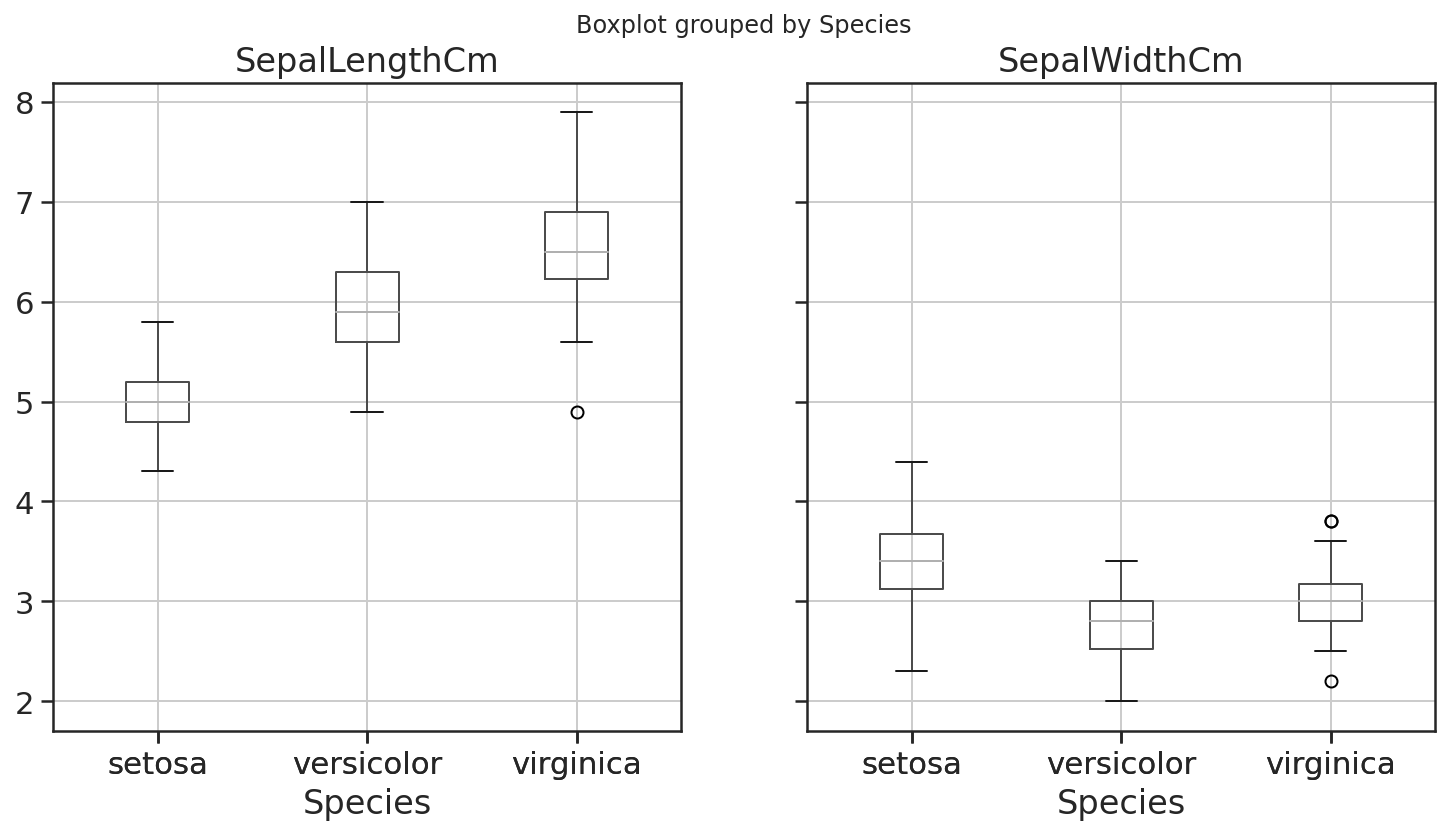

In [161]:
## 可视化分组箱线图
Iris.iloc[:,1:6].boxplot(column=["SepalLengthCm", "SepalWidthCm"],
                         by = "Species",figsize = (12,6))

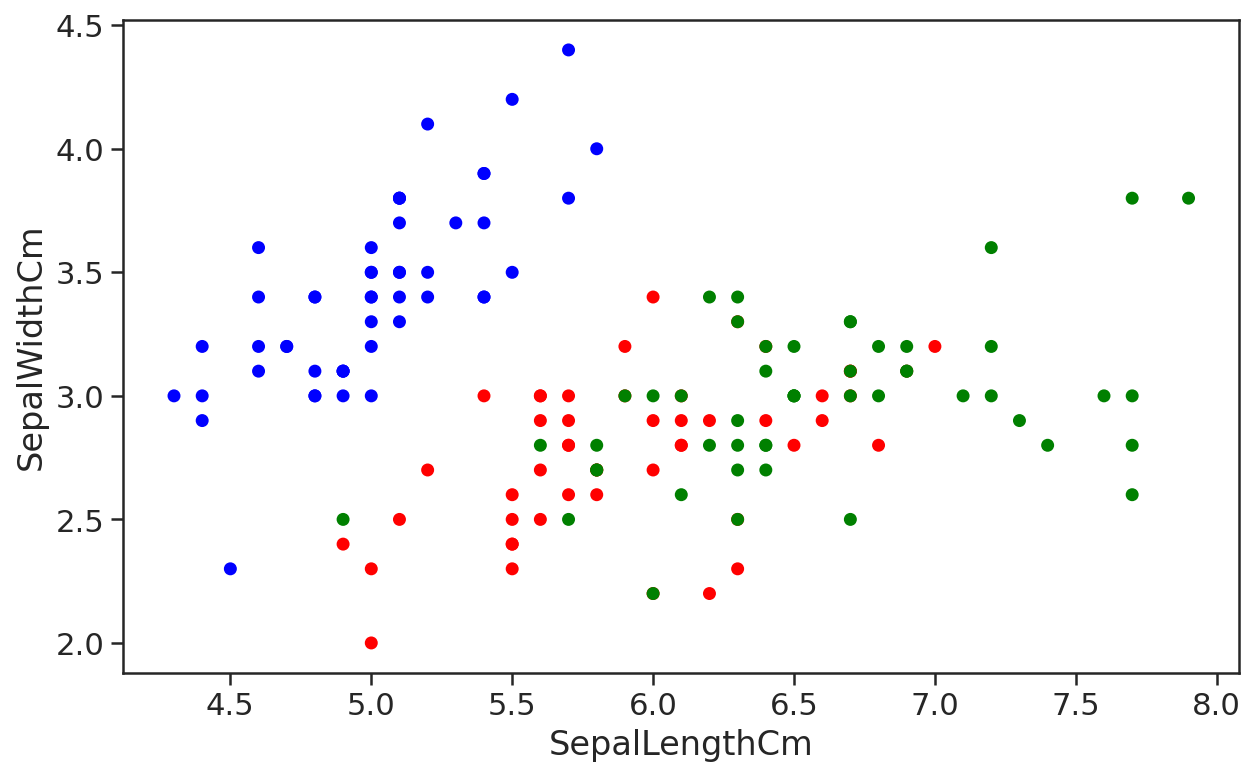

In [162]:
## 可视化散点图
## 设置颜色映射
col = Iris.Species.map({"setosa":"blue", "versicolor":"red",
                        "virginica":"green"})
Iris.plot(kind = "scatter",x = "SepalLengthCm",y = "SepalWidthCm",
          s = 30, c = col,figsize = (10,6))

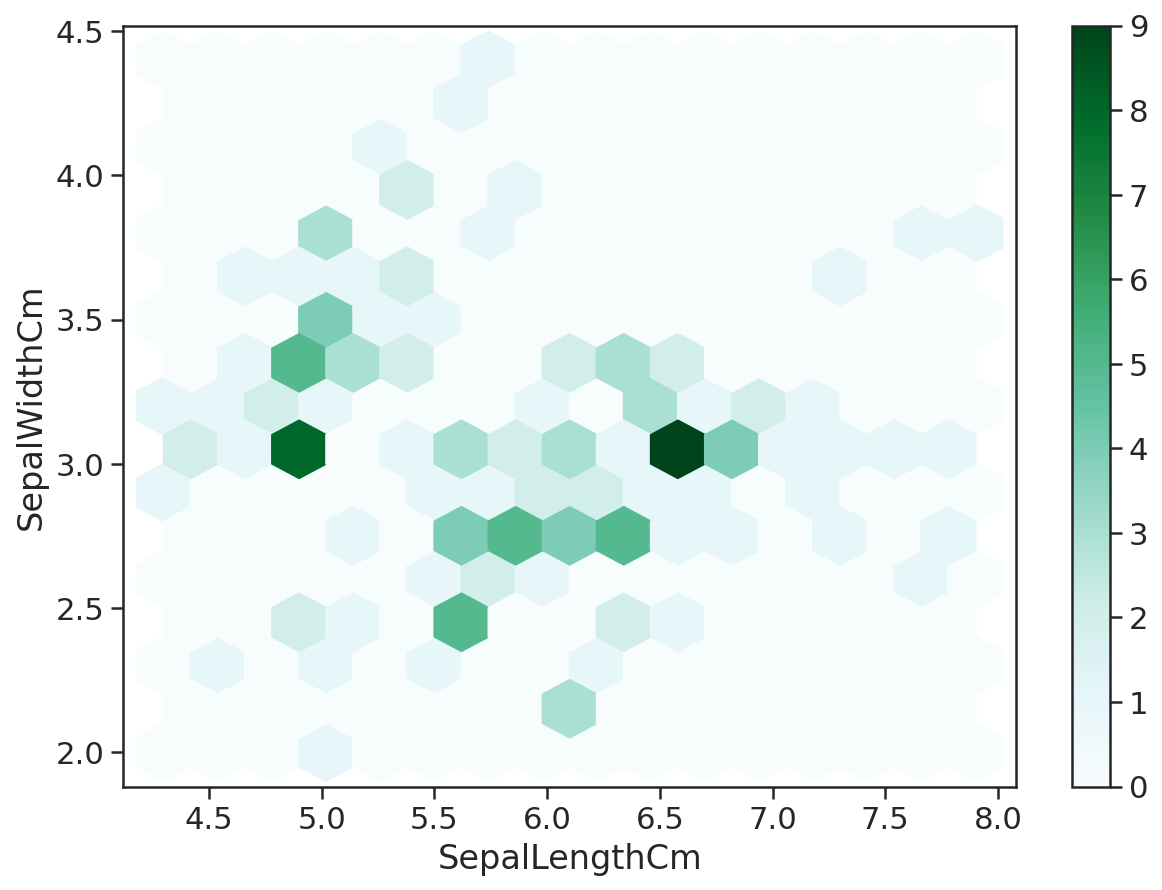

In [163]:
## 可视化六边形热力图
Iris.plot(kind = "hexbin",x = "SepalLengthCm",y = "SepalWidthCm",
          gridsize = 15,figsize = (10,7),sharex = False)

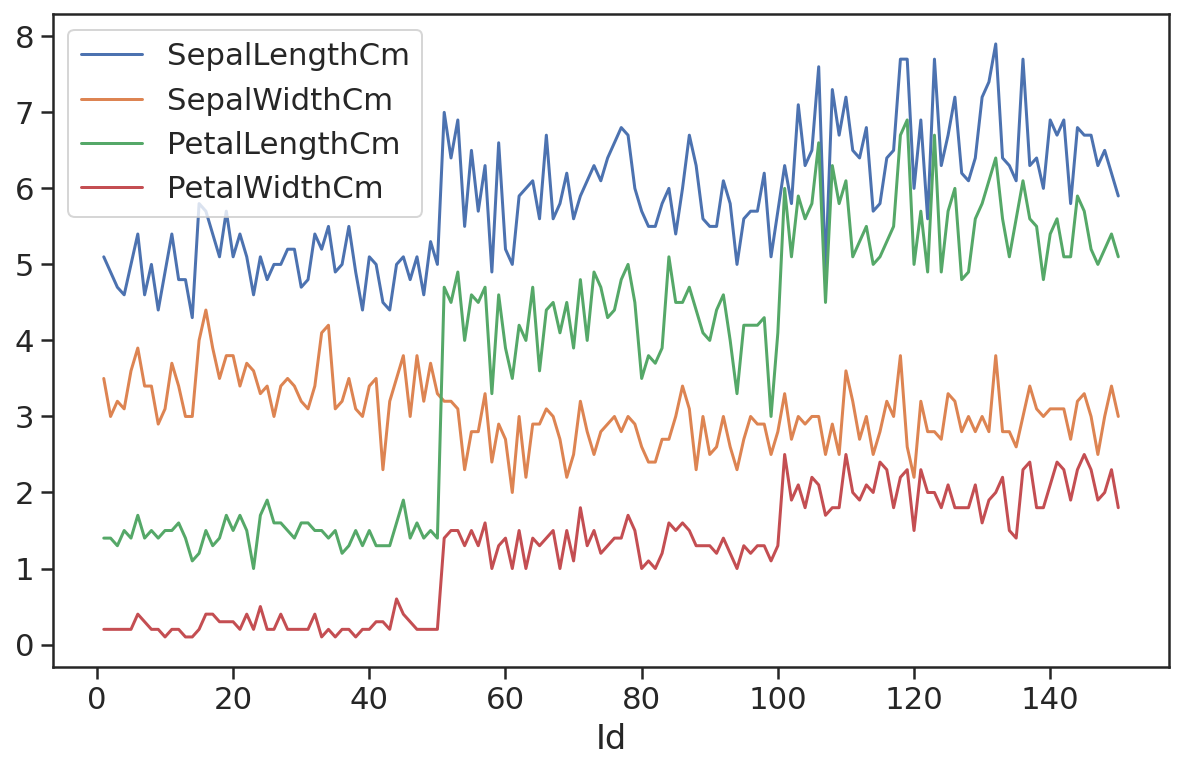

In [164]:
## 折线图
Iris.iloc[:,0:5].plot(kind = "line",x = "Id",figsize = (10,6))

#### 1.4.3 Matplotlib库入门

In [165]:
## 导入相关可是户模块
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
## 图像显示中文的问题
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
## 设置图像在可视化时使用的主题
import seaborn as sns 
sns.set(font= "Kaiti",style="ticks",font_scale=1.4)

#### 二维可视化图像

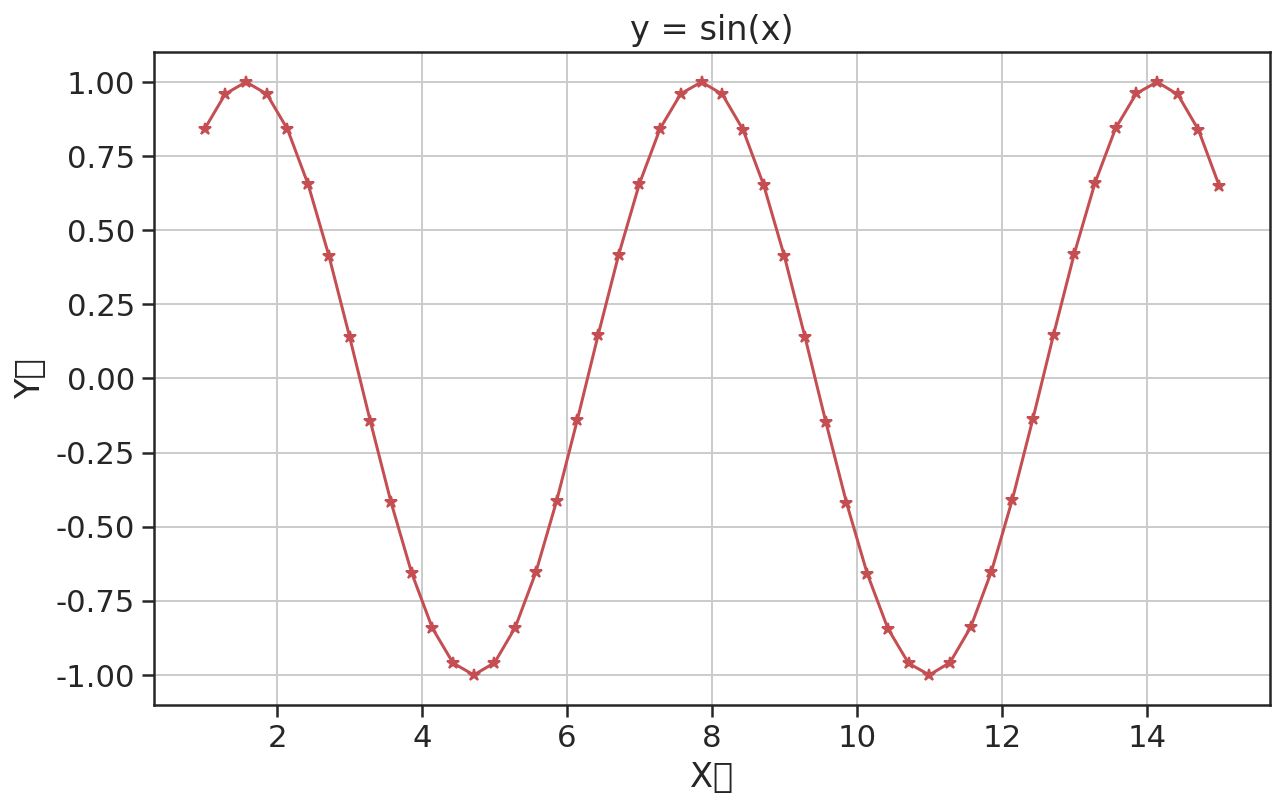

In [166]:
## 绘制一条曲线
X = np.linspace(1,15)
Y = np.sin(X)
plt.figure(figsize=(10,6))     # 图像的大小(宽：10，高：6)
plt.plot(X,Y,"r-*")            # 绘制X，Y,红色、直线、星形
plt.xlabel("X轴")              # X坐标轴的label
plt.ylabel("Y轴")              # Y坐标轴的label
plt.title("y = sin(x)")       # 图像的名字title
plt.grid("on")                # 图像中添加网格线
plt.show()                    #显示图像

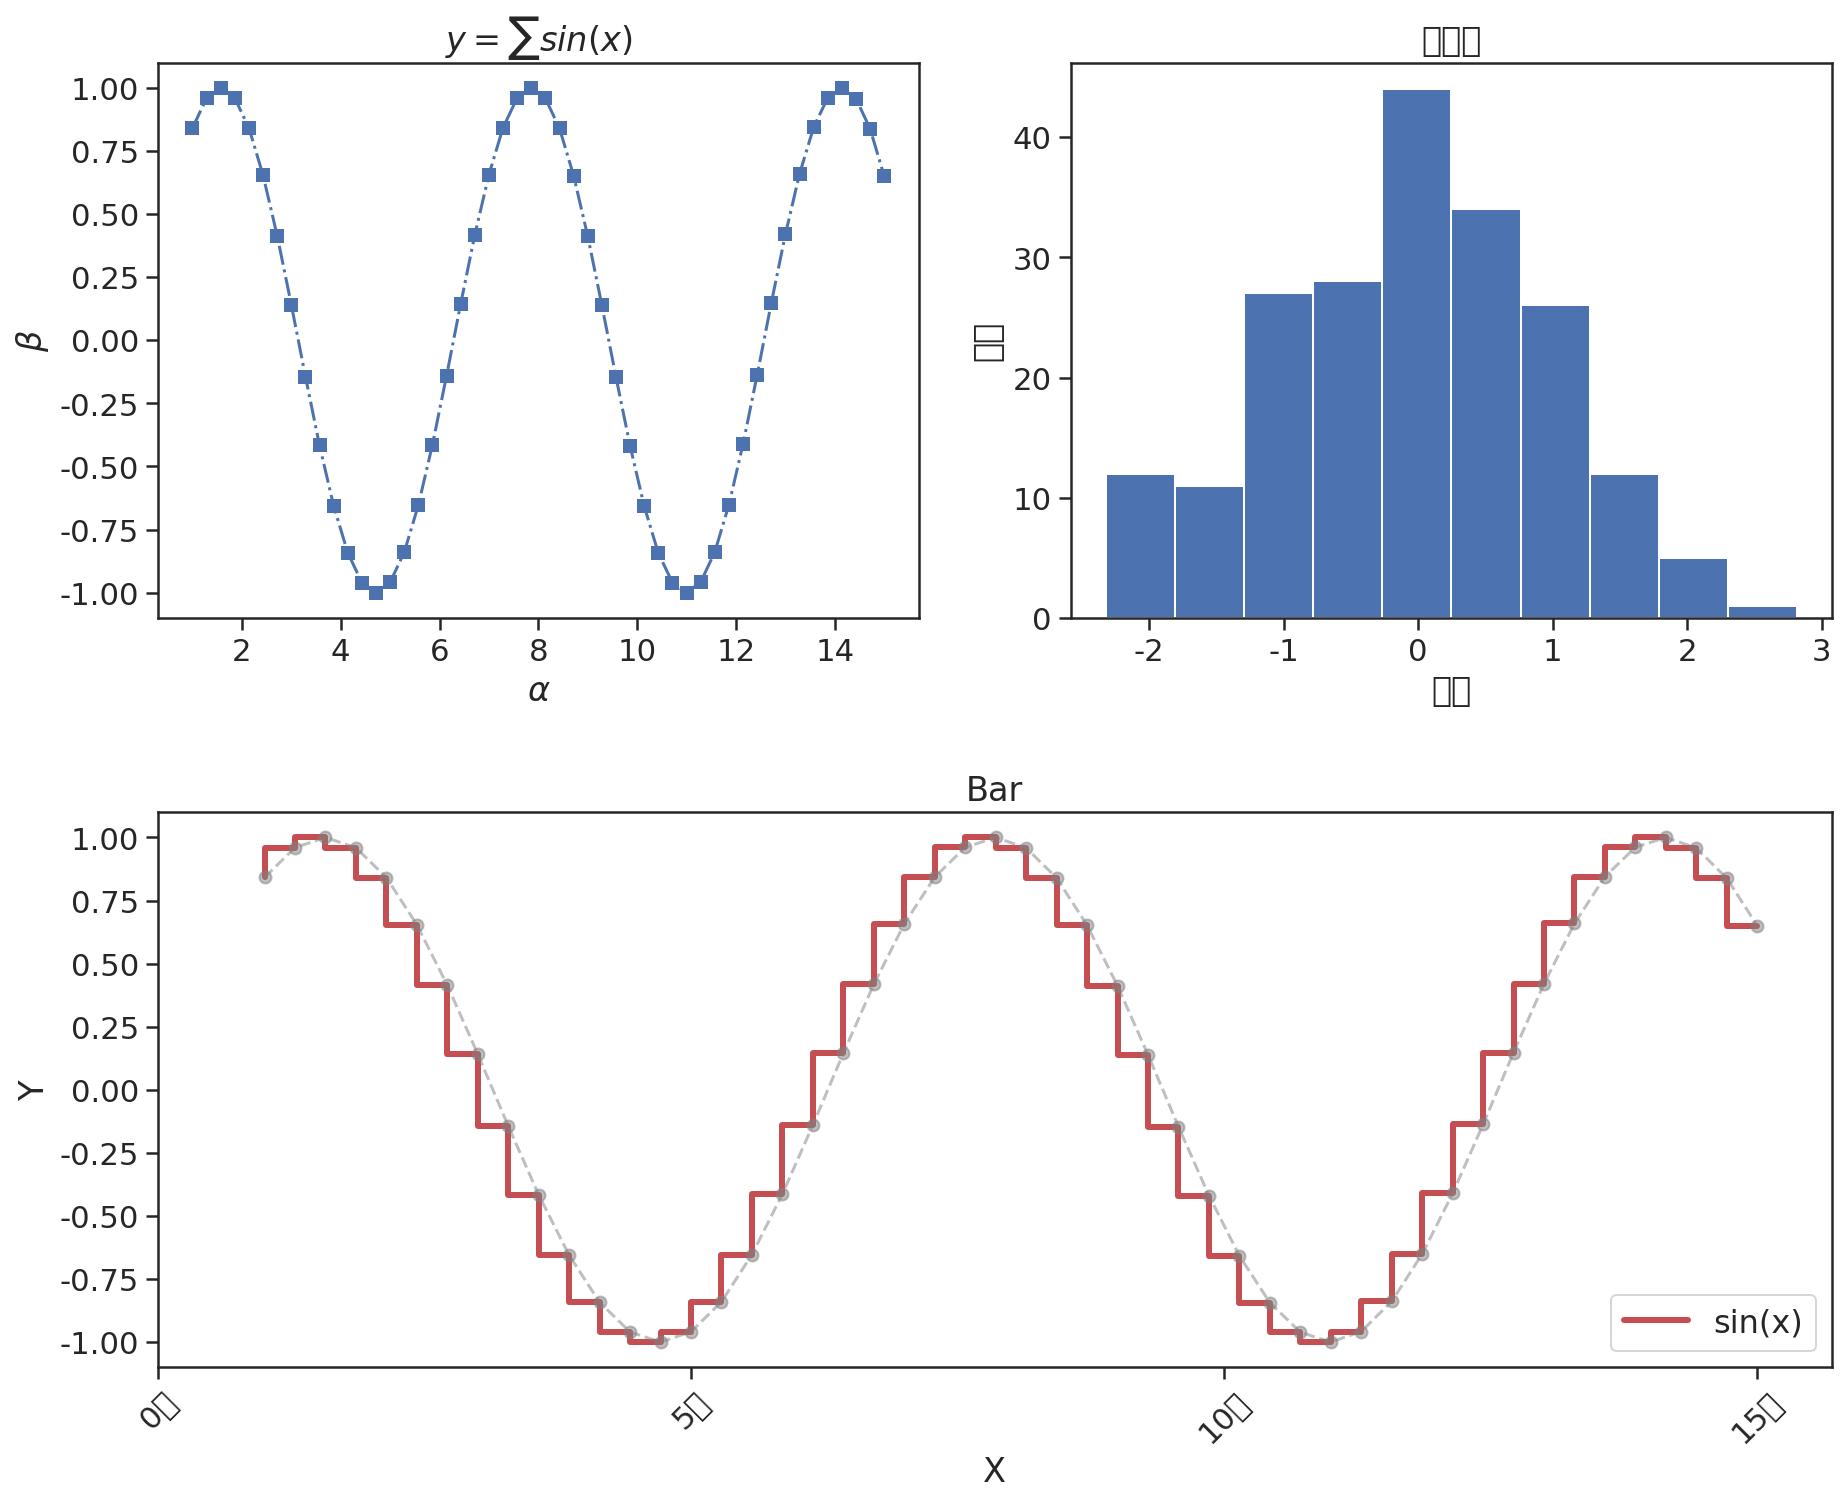

In [167]:
## 在可视化时将窗口切分为多个子窗口，分别绘制不同的图像
plt.figure(figsize=(15,12))       # 图像的大小(宽：15，高：12)
plt.subplot(2,2,1)                # 4个子窗口中的第1个子窗口
plt.plot(X,Y,"b-.s")              # 绘制X，Y,蓝色、虚线、矩形点
plt.xlabel(r"$\alpha$")           # X坐标轴的label,使用latex公式
plt.ylabel(r"$\beta$")            # Y坐标轴的label,使用latex公式
plt.title("$y = \sum sin(x)$")    # 图像的名字title,使用latex公式

plt.subplot(2,2,2)                # 4个子窗口中的第2个子窗口
histdata = np.random.randn(200,1) # 生成数据
plt.hist(histdata, 10)            # 可视化直方图
plt.xlabel("取值")           # X坐标轴的label,使用中文
plt.ylabel("频数")           # Y坐标轴的label,使用中文
plt.title("直方图")          # 图像的名字title,使用中文

plt.subplot(2,1,2)                 # 4个子窗口中的第3,4个子窗口合为一个窗口
plt.step(X,Y,c="r",label = "sin(x)",linewidth=3) #阶梯图，红色，线宽3，添加标签
plt.plot(X,Y,"o--", color="grey", alpha=0.5)     # 添加灰色曲线
plt.xlabel("X",)    # X坐标轴的label
plt.ylabel("Y",)    # Y坐标轴的label
plt.title("Bar",)   # 图像的名字title
plt.legend(loc = "lower right",fontsize = 16)   # 图例在右下角，字体大小为16
xtick = [0,5,10,15]           # 单独设置X轴坐标系取值
xticklabel = [str(x)+"辆" for x in xtick]
plt.xticks(xtick,xticklabel,rotation = 45)# x轴的坐标取值,倾斜45度
plt.subplots_adjust(hspace = 0.35)## 调整子图像之间的水平空间距离
plt.show()

#### 三维可视化图像

In [168]:
## 准备要使用的网格数据
x = np.linspace(-4,4,num=50)
y = np.linspace(-4,4,num=50)
X,Y = np.meshgrid(x,y)
Z = np.sin(np.sqrt(X**2+Y**2))

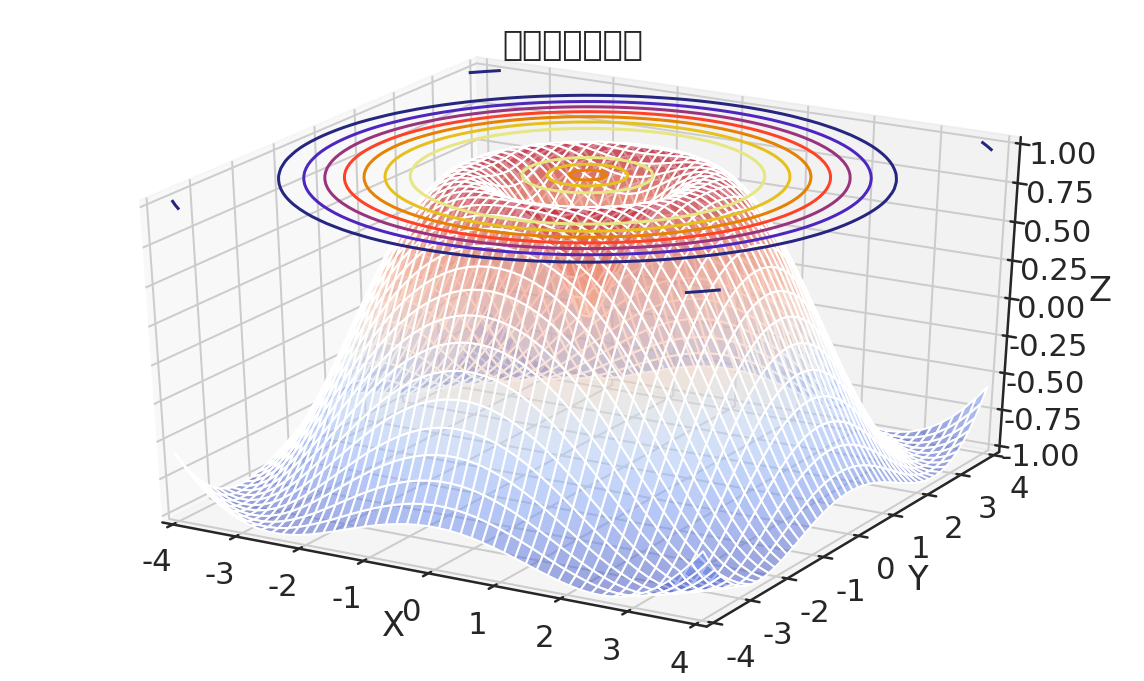

In [169]:
## 可视化3维曲面图
fig = plt.figure(figsize=(10,6))
## 将坐标系设置为3D
ax1 = fig.add_subplot(111, projection= "3d")
## 绘制曲面图，rstride:行的跨度, cstride:列的跨度, cmap:颜色,alpha:透明度
ax1.plot_surface(X, Y, Z, rstride=1, cstride=1,alpha= 0.5 ,cmap=plt.cm.coolwarm)
## 绘制Z轴方向的等高线,投影位置在Z＝1的平面
cset = ax1.contour(X, Y, Z, zdir="z", offset = 1,cmap=plt.cm.CMRmap)
ax1.set_xlabel("X") 
ax1.set_xlim(-4, 4)           ## 设置X轴的绘图范围
ax1.set_ylabel("Y") 
ax1.set_ylim(-4, 4)           ## 设置Y轴的绘图范围
ax1.set_zlabel("Z")
ax1.set_zlim(-1, 1)           ## 设置Z轴的绘图范围
ax1.set_title("曲面图和等高线")
plt.show()

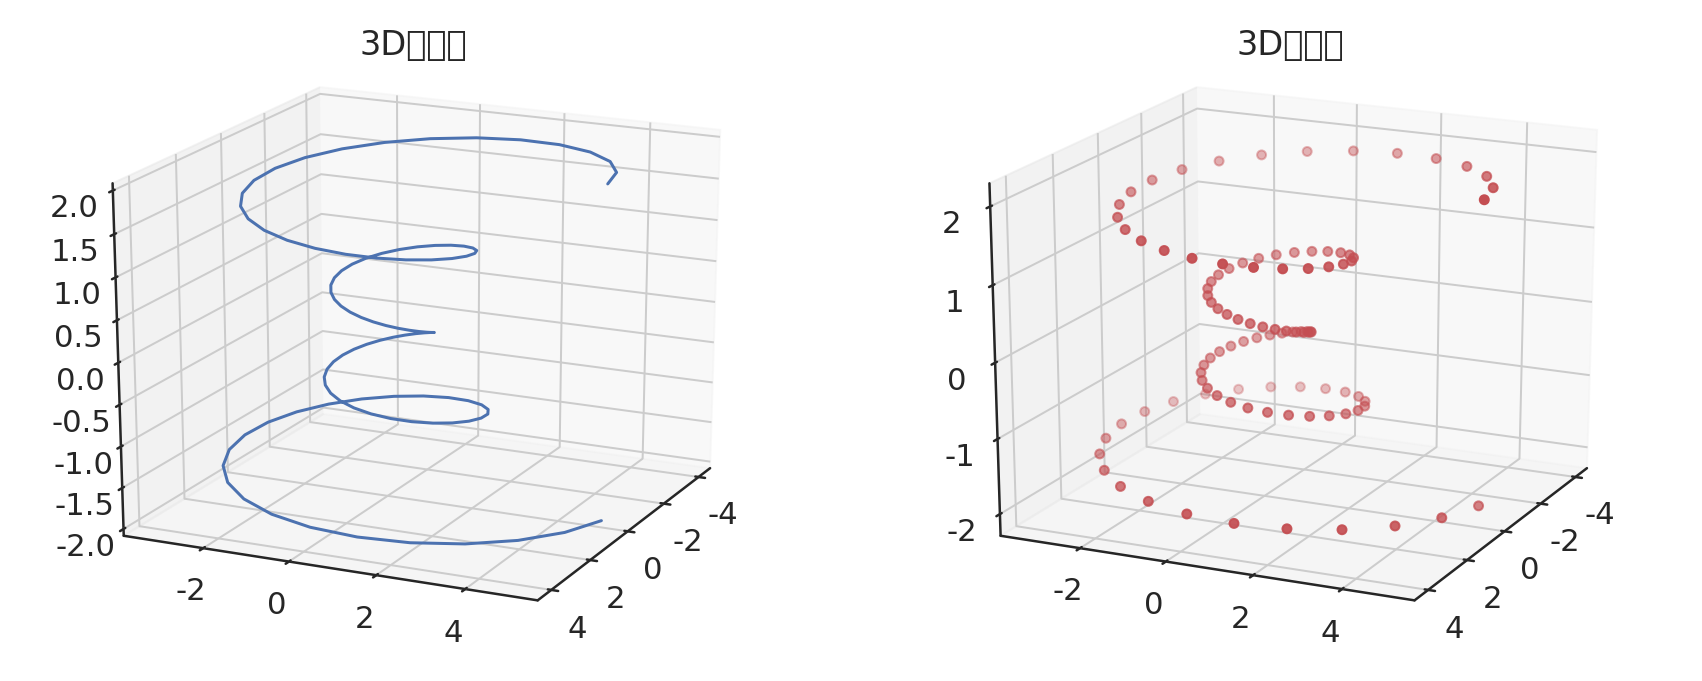

In [170]:
## 准备数据
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100) # 角度
z = np.linspace(-2, 2, 100)                     # Z坐标
r = z**2 + 1                                    # 半径
x = r * np.sin(theta)                           # X坐标
y = r * np.cos(theta)                           # y坐标
## 在子图中绘制三维的图像
fig = plt.figure(figsize=(15,6))
## 将坐标系设置为3D
ax1 = fig.add_subplot(121, projection= "3d")  #子图1
ax1.plot(x, y, z,"b-")                #绘制红色三维曲线图
ax1.view_init(elev=20,azim=25)   # 设置轴的方位角和高程
ax1.set_title("3D曲线图")

ax2 = plt.subplot(122,projection = "3d")  #子图2
ax2.scatter3D(x,y,z,c = "r",s = 20)     #绘制红色三维散点
ax2.view_init(elev=20,azim=25)   # 设置轴的方位角和高程
ax2.set_title("3D散点图")
plt.subplots_adjust(wspace = 0.1) ## 调整子图像之间的空间距离
plt.show()

In [173]:
!cp /content/drive/MyDrive/Colab/data/ch1/firstfig.png /content

#### 可视化图片

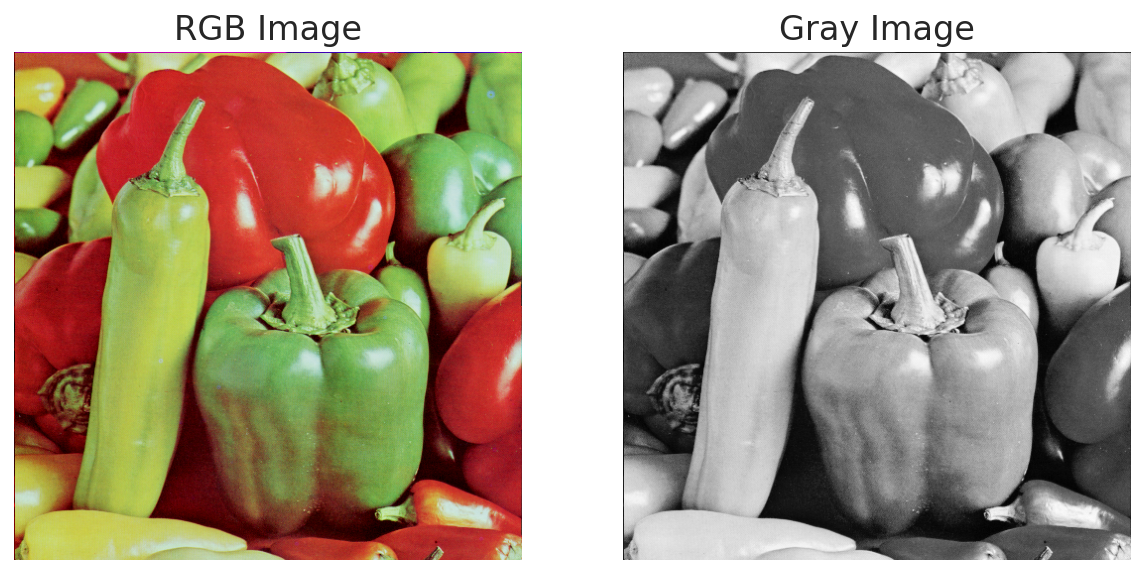

In [174]:
## 数据准备
from skimage.io import imread  ## 从skimage库中引入读取图片的函数
from skimage.color import rgb2gray ## 从skimage库中引入将RGB图片转化为灰度图像的函数
im = imread("firstfig.png")
imgray = rgb2gray(im)

## 可视化图片
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)  ## RGB图像
plt.imshow(im)
plt.axis("off")     ## 不显示坐标轴
plt.title("RGB Image")

plt.subplot(1,2,2)  ## 灰度图像
plt.imshow(imgray,cmap = plt.cm.gray)
plt.axis("off")     ## 不显示坐标轴
plt.title("Gray Image")
plt.show()

### 1.5 机器学习模型的使用初探

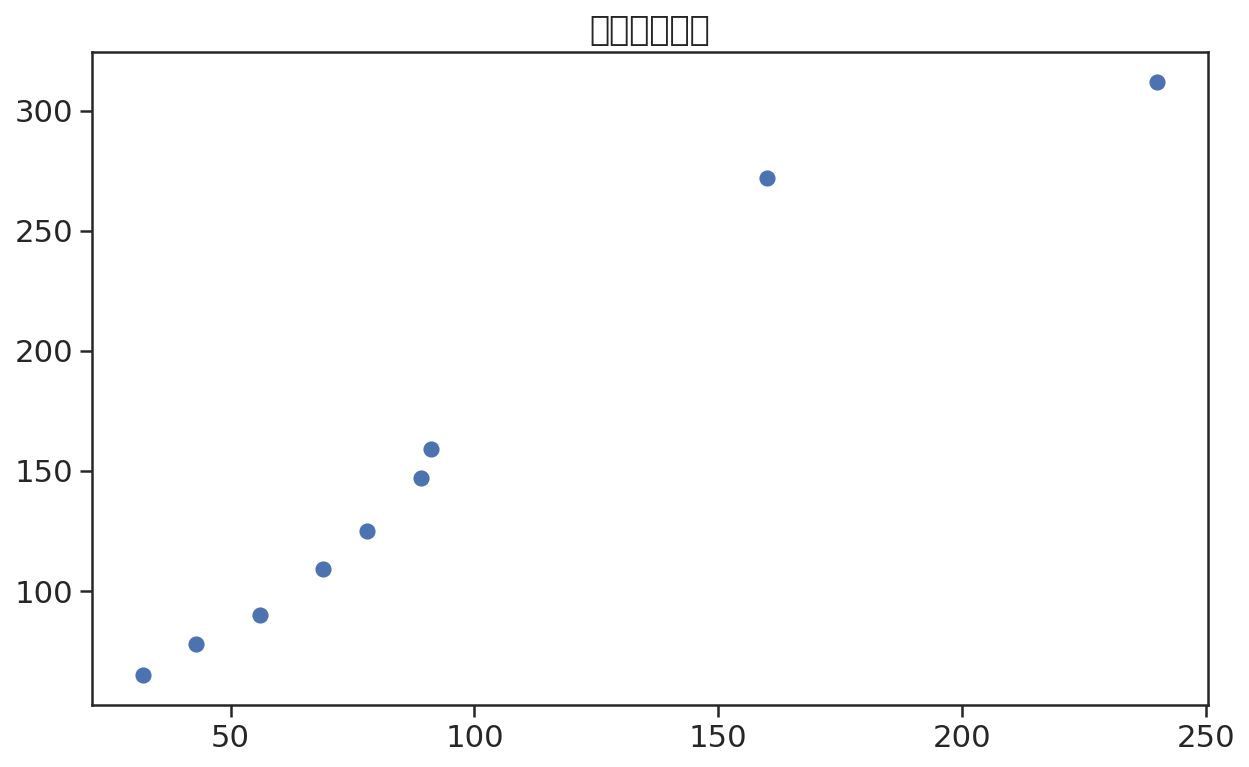

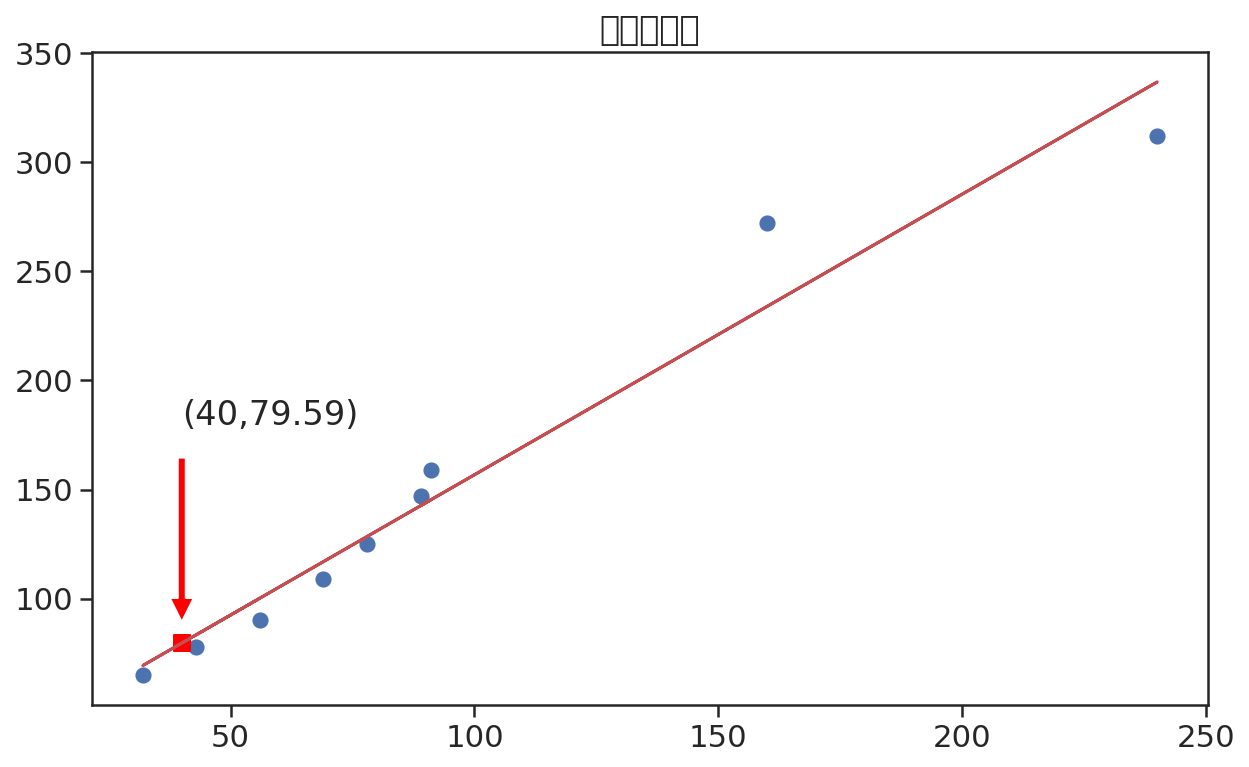

In [175]:
#导入库
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
      
x=np.array([56,32,78,160,240,89,91,69,43])
y=np.array([90,65,125,272,312,147,159,109,78])
      
#数据导入与处理，并进行数据探索
X = x.reshape(-1,1)
Y = y.reshape(-1,1)
plt.figure(figsize=(10,6)) # 初始化图像窗口
plt.scatter(X,Y,s = 50)  #原始数据的图
plt.title("原始数据的图")
plt.show()
      
#训练模型和预测
model = LinearRegression()
model.fit(X,Y)
x1=np.array([40,]).reshape(-1,1)   # 带预测数据
x1_pre = model.predict(np.array(x1)) #预测面积为40平米时房价
      
#可视化模型预测结果
plt.figure(figsize=(10,6))
plt.scatter(X,Y,s = 50)  
# 带预测值的位置      
plt.scatter(x1, x1_pre,color="red",s = 60,marker = "s") 
plt.annotate("(40,79.59)", xy=(x1, x1_pre),xytext=(x1,x1_pre+100),
             arrowprops=dict(facecolor="red", shrink=0.1))
#将训练数据预测值使用直线表示
b=model.intercept_ #截距
a=model.coef_  #斜率
y = a*x +b          
y= y.tolist()[0]
plt.plot(x,y,"r")
plt.title("模型预测值")
plt.show()

In [176]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# 取得 Fashion-MNIST 的訓練資料集，建立 Dataset
training_data = datasets.FashionMNIST(
    root="data",            # 資料放置路徑
    train=True,             # 訓練資料集
    download=True,          # 自動下載
    transform=ToTensor(),   # 資料轉換函數
)

# 下載 Fashion-MNIST 的測試資料集，建立 Dataset
test_data = datasets.FashionMNIST(
    root="data",            # 資料放置路徑
    train=False,            # 測試資料集
    download=True,          # 自動下載
    transform=ToTensor(),   # 資料轉換函數
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [177]:
# 批次載入資料筆數
batch_size = 64

# 建立 DataLoader
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [178]:
# 測試以 DataLoader 載入資料
for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [181]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import gzip
import os
import matplotlib

NameError: ignored

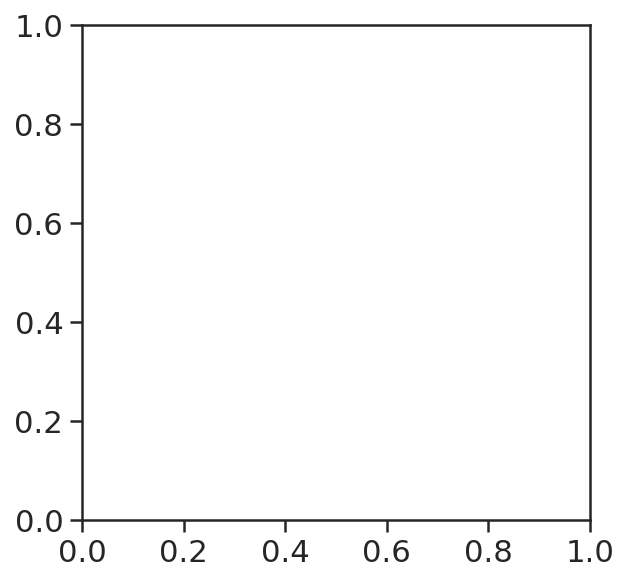

In [182]:
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(trainX[10])
plt.subplot(222), plt.imshow(trainX[20])